# Steam Data Analysis. Analysis of the datasets structure and cleanup

## Introduction

After data gathering, we have four csv files:

* `steam_app_data.csv`: Application and DLC data for all IDs from Steam Storefront (2022, April 26)
* `steamspy_data.csv`: Application data from SteamSpy for the same IDs (2022, April 27)
* `steamreviews_data.csv`: Summary review data from Steam API (2022, April 28)
* `missing_ids.csv`: List of the Apps not included in the dataset

Almost all the data necessary for the analysis should be at the `steam_app_data.csv`.
In `steamspy_appid.csv` we have additional information which might be very useful:

* Positive Reviews (count)
* Negative Reviews (count)
* Average and Medians of Concurrent Players (several columns)
* Peak Concurrent Players (ccu column)
* Owners estimate, by using Steam Spy algorithm (wide ranges)
* Tags (list)

Due to how data is gathered on SteamSpy there might be some discrepancies so the third dataset `steamreviews_data.csv` with the review summary data was downloaded from the Steam AppReviews API and used as an additional source of information:

* Review Score
* Review Score (as description string)
* Positive Reviews (count)
* Negative Reviews (count)
* Total Reviews (count)

In this notepad I'll go through each of the data table comparing them and taking notice for the clean-up and column parsing when necessary. There goals here are: 

* Prepare the table structure that will be exported and used later in the analysis/visualization creation
* Make the fields/tables as easy to uperate later in analysis as possible
* Keep as much data as possible (even with the null fields - even these data might be useful for the dataset users)
* Document the changes and prepare a streamlined automated process for the future updates

### TODO:
* Extend tests after pre-processing

### Imports

In [1]:
# Module imports
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time
import re
import ast
import itertools

# third-party imports
import numpy as np
import pandas as pd

In [2]:
# Loading data tables
storefront = pd.read_csv('../data/processing/steam_app_data.csv', dtype={'required_age': 'str', 'download_appid': 'int'})
steamspy = pd.read_csv('../data/processing/steamspy_data.csv')
reviews = pd.read_csv('../data/processing/steamreviews_data.csv', dtype={'download_appid': 'int'})
missing_ids = pd.read_csv('../data/processing/missing_ids.csv')

In [3]:
# Setting some constants
# usd/eu exchange rate at the time of collection
usd_eu_rate = 0.95
# date of the dataset collection
df_collection_date = pd.Timestamp(2022,6,22)

### Utility functions
Let's define some utility functions used for processing and troubleshooting:

In [4]:
def getSteamLink(df):
    '''
        Give us the name and links to any subseries of apps, for troubleshooting.
    '''
    for item in df.index:
        print(f'{df.loc[item]["name"]} https://store.steampowered.com/app/{str(item)}')

In [5]:
def export_data(df, filename, index=False, list_columns = []):
    '''
    Export dataframe to the csv file in export folder'.
    
        filename: file name string without file extension
        index: boolean, to export index as well or not
        list_columns: list columns to transform from '['item']' to the simple 
            ';' delimited list
    '''
    filepath = '../data/export/' + filename + '.csv'
    
    def list_convert(input_list):
        try:       
            return ';'.join(str(item) for item in input_list)
        except Exception as ex:
            print(input_list)
            print(ex)
            raise(ex)
    
    for col in list_columns:
        df[col].fillna({i: [] for i in storefront.index},inplace = True)
        df[col] = df[col].apply(lambda x: list_convert(x))

        
    df.to_csv(filepath, index=index)

    print(f'Exported {filename} to "{filepath}"')

In [6]:
def boolean_df(item_lists, unique_items):
    '''
    Create boolean dataframe from from the item list series and 
    a list of unique item values
    
        items_lists: pandas series with item lists
        unique_items: list with the unique item valaues
    
    '''
    
    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [7]:
# utility function to add the removed IDs to the missing_ids
def removeIDs(df, ids_list, reason):
    '''
    Remove ids and add them to the missing_ids with the reason
    '''
    global missing_ids
    
    # removing ids from df
    df = df.loc[~df.index.isin(ids_list)]
    
    # adding ids to the missing_ids
    temp_df = pd.DataFrame(ids_list,columns =['appid'])
    temp_df['reason'] = reason
    missing_ids = pd.concat([missing_ids, temp_df]).reset_index(drop=True)
    return df

## Preparing data

As I've noted earlier, here 

Let's start with the overall structure of our tables - number of columns, total data counts and the amount of non-null data.

In [8]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 41 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108866 non-null  object
 1   name                     108854 non-null  object
 2   steam_appid              109535 non-null  int64 
 3   required_age             108866 non-null  object
 4   is_free                  108866 non-null  object
 5   controller_support       27253 non-null   object
 6   dlc                      10159 non-null   object
 7   detailed_description     108682 non-null  object
 8   about_the_game           108681 non-null  object
 9   short_description        108681 non-null  object
 10  fullgame                 36358 non-null   object
 11  supported_languages      108689 non-null  object
 12  header_image             108866 non-null  object
 13  website                  62788 non-null   object
 14  pc_requirements     

In [9]:
steamspy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106898 entries, 0 to 106897
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   appid            106898 non-null  int64  
 1   name             106657 non-null  object 
 2   developer        94979 non-null   object 
 3   publisher        85641 non-null   object 
 4   score_rank       52 non-null      float64
 5   positive         106898 non-null  int64  
 6   negative         106898 non-null  int64  
 7   userscore        106898 non-null  int64  
 8   owners           106898 non-null  object 
 9   average_forever  106898 non-null  int64  
 10  average_2weeks   106898 non-null  int64  
 11  median_forever   106898 non-null  int64  
 12  median_2weeks    106898 non-null  int64  
 13  price            95336 non-null   float64
 14  initialprice     95347 non-null   float64
 15  discount         95347 non-null   float64
 16  languages        95128 non-null   obje

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   appid              109535 non-null  int64 
 1   review_score       109535 non-null  int64 
 2   review_score_desc  109535 non-null  object
 3   total_positive     109535 non-null  int64 
 4   total_negative     109535 non-null  int64 
 5   total_reviews      109535 non-null  int64 
 6   download_appid     109535 non-null  int32 
dtypes: int32(1), int64(5), object(1)
memory usage: 5.4+ MB


We have roughly 100000 App IDs in each of the tables.

**Steam Storefront** data has some seemingly optional information in these columns: *dlc*, *fullgame*, *website*, *legal_notice*, *drm_notice*, *ext_user_account_notice*,   *demos*, *metacritic*, *reviews*, *movies*, *recommendations*, *achievements*. 

*developers*, *publishers*, *demos*, *price_overview*, *packages* have quite a big number of nulls that definetely need some investigating. Some other columns also haave a small number of null data.

**Steam Reviews** data don't seem to have any nulls.

**SteamSpy** data also have some fields with a noticeable amount of nulls: *developer*, *publisher*, *score_rank*, *price*, *initialprice*, *discount*, *languages*, *genre*.

The total numbers of App IDs is a bit different between the table. There is one noticeable 'Feature' in the Steam Storefront API - it doesn't return the data for the games that are not available in the regioin. I've downloaded the data from the Netherlands and it might explain some games missing as they are not available in the region. The small difference between the Steam Reviews and SteamSpy might be caused by the different dates the data was gathered.

There is some data that appears in two data tables. Since the data might differ both in the format and content, I'll check both and decide how they are handled as we move along.

| Field 1 | Field 2 |
| --- | --- |
| storefront.name | steamspy.name |
| developers | developer |
| publishers | publisher |
| storefront.price_overview | steamspy.price/initialprice/discount |
| storefront.genres | steamspy.genre |
| storefront.supported_languages | steamspy.languages |
| reviews.review_score | steamspy.userscore |
| reviews.total_positive | steamspy.positive |
| reviews.total_negative | steamspy.negative |

I'll start with the **most important fields** to check if we'll have to remove some data right from the start.

### Unique IDs

App IDs shuld be unique but we should check if we have duplicated app ids in our dataframes. We used an iterative process, and it could be possible that some ids when requested redirect us to a new id. This has been observed trying to access directly in the Steam Store page with some of the 'missing' ids. For instance, different versions of Guild Wars 2 all lead us to a unique store page on Steam, as the old versions do not exist anymore.

Sadly, in some cases it leads to some issues as app_id for the same app might be different in different datasets, for example:

In [11]:
storefront[storefront['steam_appid'].isin([34330,201270])]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,download_appid,last_modified
1790,game,Total War: SHOGUN 2,34330,0.0,False,NaN,"[223180, 201279, 201277, 34348, 34342, 34343, ...",<h1>Total War: SHOGUN 2 out now for Linux.</h1...,<strong>MASTER THE ART OF WAR</strong><br>\t\t...,Total War: SHOGUN 2 is the perfect mix of real...,...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 27337},"{'total': 106, 'highlighted': [{'name': 'Stran...","{'coming_soon': False, 'date': '14 Mar, 2011'}","{'url': 'https://support.sega.co.uk', 'email':...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",201270,1603131194


In [12]:
steamspy[steamspy['appid'].isin([34330,201270])]

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
1798,201270,Total War: SHOGUN 2,"CREATIVE ASSEMBLY, Feral Interactive (Mac), Fe...","SEGA, Feral Interactive (Mac), Feral Interacti...",NaN,47596,4234,0,"2,000,000 .. 5,000,000",0,0,0,0,2999.0,2999.0,0.0,"English, Czech, French, German, Italian, Polis...",Strategy,2,"{'Strategy': 1114, 'Historical': 629, 'Turn-Ba..."


In [13]:
reviews[reviews['appid'].isin([34330,201270])]

,appid,review_score,review_score_desc,total_positive,total_negative,total_reviews,download_appid
1790,201270,8,Very Positive,47570,4107,51677,201270


In [14]:
missing_ids[missing_ids['appid'].isin([34330,201270])]

,appid,reason


In [15]:
storefront[storefront.steam_appid != storefront.download_appid][['name','steam_appid','download_appid','last_modified']]

,name,steam_appid,download_appid,last_modified
785,Tom Clancy's Splinter Cell Conviction™ Deluxe ...,33220,33229,1579096325
1309,"Warhammer 40,000: Dawn of War II: Retribution",56400,56437,1603127845
1398,IL-2 Sturmovik: Cliffs of Dover,63950,63970,1447354055
1742,Call of Duty®: Modern Warfare® 3,42680,115300,1646849563
1790,Total War: SHOGUN 2,34330,201270,1603131194
3461,Wizardry 6: Bane of the Cosmic Forge,245410,245430,1655319309
21565,Train Sim World®: Rapid Transit,577358,577359,1582801218
24064,False Shelter,621150,621160,1492022936
26607,Light in the dark,669600,669620,1516123105
33413,7 Soccer: a sci-fi soccer tale,788500,788510,1518470860


In this case, the same App is present in different tables under different AppIDs. And it looks like we have removed a duplicate during the collectioin phase. It looks like:
1) JSONs returned by the Steam Storefront are the same
2) Review results seem to be the same for both appids (within a few days difference between download times)
3) steam_appid, returned in the Storefront response might be different from the appid used by the Steam itself: Links to resources use the new AppIDs almost everywhere (except, interestingly, achivements images that seem to be not updated by the publisher)

Fortunately, we have the appid we used for downloading saved in 'download_appid' column and we can notice that:
1) Old appids don't seem to be returned by the IStoreService API
2) SteamSpy has different stats returned by the old and new Appid
3) Old appid is only present in the Storefront

We can replace 'steam_appid' with the 'download_id' when it's different and add a note in the missing_ids. After that we can remove 'download_id' as not being relevant anymore.

#### [Subroutine] steam_appid: Fixing


In [16]:
# steam_appid fixing old AppIds
def appid_fix(df, missing_df):
    def replace_id(row, removed_ids, missing_ids):
        # replacing id in the row if it answers the conditions
        print('Replacing', row['steam_appid'], ' with ', row['download_appid'], ' for ', row['name'])
        missing_ids.append(row['download_appid'])
        removed_ids.append(row['steam_appid'])
        return row['download_appid']
    
    df = df.copy()
    # parsing header images to parsed_id
    # select only rows that have different Storefront and download_id IDs
    mask = (df['steam_appid'] != df['download_appid'])
    # replacing ids
    removed_ids = []
    missing_ids = []
    df.loc[mask,'steam_appid'] = df[mask].apply(lambda row: replace_id(row, removed_ids, missing_ids), axis=1)
    temp_df = pd.DataFrame(removed_ids,columns =['appid'])
    temp_df['reason'] = 'Storefront appid fix'
    missing_df =  missing_df.loc[~missing_df.appid.isin(missing_ids)]
    missing_df = pd.concat([missing_df, temp_df]).reset_index(drop=True)
    # dropping download_appid
    df.drop('download_appid', inplace = True, axis = 1)
    return df, missing_df

In [17]:
storefront, missing_ids = appid_fix(storefront, missing_ids)

Replacing 33220  with  33229  for  Tom Clancy's Splinter Cell Conviction™ Deluxe Edition
Replacing 56400  with  56437  for  Warhammer 40,000: Dawn of War II: Retribution
Replacing 63950  with  63970  for  IL-2 Sturmovik: Cliffs of Dover
Replacing 42680  with  115300  for  Call of Duty®: Modern Warfare® 3
Replacing 34330  with  201270  for  Total War: SHOGUN 2
Replacing 245410  with  245430  for  Wizardry 6: Bane of the Cosmic Forge
Replacing 577358  with  577359  for  Train Sim World®: Rapid Transit
Replacing 621150  with  621160  for  False Shelter
Replacing 669600  with  669620  for  Light in the dark
Replacing 788500  with  788510  for  7 Soccer: a sci-fi soccer tale
Replacing 889530  with  889600  for  Sharp
Replacing 22330  with  900883  for  The Elder Scrolls IV: Oblivion® Game of the Year Edition Deluxe
Replacing 38480  with  901147  for  Earthworm Jim
Replacing 24980  with  901242  for  Mass Effect 2 Digital Deluxe Edition
Replacing 31220  with  901399  for  Sam & Max: The Devi

Checking for duplicates just in case:

In [18]:
storefront['steam_appid'].duplicated().sum()

0

In [19]:
steamspy['appid'].duplicated().sum()

0

In [20]:
reviews['appid'].duplicated().sum()

6

There are might be some duplicates in tables - I'll need to check the data collecting functions to remove the possibility of the duplicates getting in laters. For now I'll just clean it up:

In [21]:
storefront = storefront.drop_duplicates(subset='steam_appid', keep='last')
steamspy = steamspy.drop_duplicates(subset='appid', keep='last')
reviews = reviews.drop_duplicates(subset='appid', keep='last')

# Steam Storefront table

Let's process Steam Storefront table by each column

### Name

In [22]:
steamspy[steamspy['name'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 1405 to 106770
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            241 non-null    int64  
 1   name             0 non-null      object 
 2   developer        8 non-null      object 
 3   publisher        8 non-null      object 
 4   score_rank       0 non-null      float64
 5   positive         241 non-null    int64  
 6   negative         241 non-null    int64  
 7   userscore        241 non-null    int64  
 8   owners           241 non-null    object 
 9   average_forever  241 non-null    int64  
 10  average_2weeks   241 non-null    int64  
 11  median_forever   241 non-null    int64  
 12  median_2weeks    241 non-null    int64  
 13  price            15 non-null     float64
 14  initialprice     15 non-null     float64
 15  discount         15 non-null     float64
 16  languages        11 non-null     object 
 17  genre     

In [23]:
storefront[storefront['name'].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
25,NaN,NaN,660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1447354286
225,NaN,NaN,8040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592490371
226,NaN,NaN,8060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592490414
325,NaN,NaN,11610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1516788252
358,NaN,NaN,12650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591334081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106272,NaN,NaN,2052352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1656390055
106284,NaN,NaN,2052700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1661871605
106576,NaN,NaN,2059990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1661934860
107569,NaN,NaN,2082480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1659784534


In [24]:
storefront[storefront['name'].isnull()]['steam_appid']

25            660
225          8040
226          8060
325         11610
358         12650
           ...   
106272    2052352
106284    2052700
106576    2059990
107569    2082480
108040    2094590
Name: steam_appid, Length: 681, dtype: int64

In [25]:
steamspy[steamspy['name'].isnull()]['appid']

1405        63970
2292       210562
3836       256090
3884       257302
6615       315210
           ...   
106109    2066110
106177    2068280
106576    2081531
106593    2082170
106770    2090150
Name: appid, Length: 241, dtype: int64

#### Name overview
Judging by the quick overview of the blank game names, there seems to be multiple causes for it:
* The application is not present in Steam
* The application is a recent release that hasn't been parsed by SteamSpy properly yet
* The application is not released yet
* The 'application' is a DLC/DLC bundle
* The application has an emoticon in the name

Let's do a crosscheck between SteamSpy and Steam Storefront data:

In [26]:
storefront[storefront['steam_appid'].isin(steamspy[steamspy['name'].isnull()]['appid'].values)].sample(10)

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
96515,game,Stop The Cult,1839670,0,False,NaN,NaN,"<strong><h2 class=""bb_tag"">STOP THE CULT, A NA...","<strong><h2 class=""bb_tag"">STOP THE CULT, A NA...",After the sudden death of their last bookkeepe...,...,"[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256863396, 'name': 'TrailerWishlist', ...",NaN,NaN,"{'coming_soon': True, 'date': 'May 2023'}","{'url': 'https://twitter.com/StopTheCult1922',...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': None}",1650123350
50386,game,Revenge,1077130,0.0,False,NaN,NaN,"Experiment with the true fear in Revenge, expl...","Experiment with the true fear in Revenge, expl...","Experiment with true fear in Revenge, explore ...",...,"[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': True, 'date': 'To Be Defined'}","{'url': '', 'email': 'contact@ryptidegames.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'This game contains s...",1657816504
55355,dlc,"Atelier Ryza: Ryza's Outfit ""Divertimento Embr...",1154590,0.0,False,NaN,NaN,Ryza's Outfit &quot;Divertimento Embrace&quot;...,Ryza's Outfit &quot;Divertimento Embrace&quot;...,Ryza's Outfit &quot;Divertimento Embrace&quot;...,...,"[{'id': '3', 'description': 'RPG'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '29 Oct, 2019'}",{'url': 'http://www.koeitecmoamerica.com/suppo...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1617347206
95166,dlc,Ruined King: A League of Legends Story™ - Mana...,1815930,0,False,full,NaN,The Manamune Sword of Yasuo playable in Ruined...,The Manamune Sword of Yasuo playable in Ruined...,The Manamune Sword of Yasuo playable in Ruined...,...,"[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '16 Nov, 2021'}","{'url': 'support.riotgames.com', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1639674088
32981,dlc,DRAGON BALL FIGHTERZ - 4 Extra Stamps,779940,0.0,False,full,NaN,"Four extra stamps including Cell, Kid Buu, Sai...","Four extra stamps including Cell, Kid Buu, Sai...","Four extra stamps including Cell, Kid Buu, Sai...",...,"[{'id': '1', 'description': 'Action'}]",NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': 'https://www.bandainamcoent.com/', 'em...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1653936386
100060,game,King Rabbit - Race,1905900,0.0,True,NaN,NaN,"<a href=""https://steamcommunity.com/linkfilter...","<a href=""https://steamcommunity.com/linkfilter...",Race with friends through dangerous obstacle c...,...,"[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256876310, 'name': 'Release Trailer', ...",NaN,NaN,"{'coming_soon': False, 'date': '22 Jun, 2022'}","{'url': 'https://www.raresloth.com', 'email': ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1655942030
38843,dlc,Screeps: World - Lifetime CPU Subscription,883940,0.0,False,NaN,NaN,This package grants lifetime indefinite access...,This package grants lifetime indefinite access...,This package grants lifetime indefinite access...,...,"[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '28 Jun, 2018'}","{'url': 'https://screeps.com', 'email': 'conta...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1624109947


#### Are there any duplicate names?

In [27]:
storefront['name'].value_counts()[storefront['name'].value_counts()>1]

Alone                                                                            6
Escape                                                                           5
Entangled                                                                        4
Space Survival                                                                   4
Lost                                                                             4
                                                                                ..
Valor                                                                            2
Ceres                                                                            2
Train Sim World® 2: Long Island Rail Road: New York - Hicksville Route Add-On    2
Chrysalis                                                                        2
REX                                                                              2
Name: name, Length: 466, dtype: int64

In [28]:
storefront[storefront['name']=="['']"]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified


We have some duplicate names, but they are really different games. There is an interesting case with 'Fantasy Grounds - Aegis of Empires 1: The Book in the Old House' that is actually 3 different applications with the same name from the same developer.

Just in case, let's check also for some weird names.

In [29]:
storefront[storefront['name'].apply(lambda x: len(str(x)) < 6)]['name'].value_counts()

Alone    6
Lost     4
Greed    3
Surge    3
Helix    3
        ..
Edge     1
Snood    1
SHELL    1
ROGO     1
Loria    1
Name: name, Length: 2829, dtype: int64

In [30]:
storefront[storefront['name'].isin(['none','None','na','Na','False','false',0,'','invalid','Invalid'])]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified


#### [Subroutine] Name cleaning

All games from the store database have valid names, except those that we should clearly remove. We keep the rest of the column from store as is.

* Replace the ['none','None','na','Na','False','false',0,'','invalid','Invalid'] names with NaN

In [31]:
# Replacing incorrect columns with NaN (or delete them)
def cleanName(storefront, remove_data = False):
    badnames = ['none','None','na','Na','False','false',0,'','invalid','Invalid', pd.NA, np.nan]
    if (remove_data):
        remove_ids = storefront[storefront.name.isin(badnames)].index.tolist()
        storefront = removeIDs(storefront, remove_ids, 'Missing app name')
    else:
        storefront['name'].mask(storefront.name.isin(badnames), pd.NA, inplace=True )
    return storefront

In [32]:
storefront = cleanName(storefront, True)

In [33]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 0 to 109534
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108854 non-null  object
 1   name                     108854 non-null  object
 2   steam_appid              108854 non-null  int64 
 3   required_age             108854 non-null  object
 4   is_free                  108854 non-null  object
 5   controller_support       27252 non-null   object
 6   dlc                      10159 non-null   object
 7   detailed_description     108678 non-null  object
 8   about_the_game           108677 non-null  object
 9   short_description        108677 non-null  object
 10  fullgame                 36356 non-null   object
 11  supported_languages      108684 non-null  object
 12  header_image             108854 non-null  object
 13  website                  62787 non-null   object
 14  pc_requirements     

In [34]:
storefront[storefront['name'].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified


### type

**Type** is an application type (you can actually designate it when downloading the data from the Steamfront. I've set it to download both dlc's and games). Besides the ones I've designated to download, there seems to be one special application reserved for Steam Gift Cards and some applications that don't have 'type' set:


In [35]:
storefront['type'].value_counts(dropna=False)

game           72449
dlc            36404
advertising        1
Name: type, dtype: int64

Let's take a look on the appliations that don't have the type set up:

In [36]:
storefront[storefront['type'].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified


It seems like these applications don't have anything set besides the appid and name. It might be either test/removed applications or the ones that don't have the data filled in. Since they don't have any valuable data, I consider them safe to remove.

#### [Subroutine] Type cleaning

All games from the store database have valid types, except those that we should clearly remove. We keep the rest of the column from store as is.

* Replace the ['none','None','na','Na','False','false',0,'','invalid','Invalid'] names with NaN

In [37]:
# Replacing incorrect columns with NaN (or delete them)
def cleanType(storefront, remove_data = False):
    badnames = ['none','None','na','Na','False','false',0,'','invalid','Invalid',pd.NA, np.nan]
    if (remove_data):
        remove_ids = storefront[storefront.type.isin(badnames)].index.tolist()
        storefront = removeIDs(storefront, remove_ids, 'Missing app type')
    else:
        storefront['type'].mask(storefront.type.isin(badnames), pd.NA, inplace=True )
    return storefront

In [38]:
storefront = cleanType(storefront, True)

In [39]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 0 to 109534
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108854 non-null  object
 1   name                     108854 non-null  object
 2   steam_appid              108854 non-null  int64 
 3   required_age             108854 non-null  object
 4   is_free                  108854 non-null  object
 5   controller_support       27252 non-null   object
 6   dlc                      10159 non-null   object
 7   detailed_description     108678 non-null  object
 8   about_the_game           108677 non-null  object
 9   short_description        108677 non-null  object
 10  fullgame                 36356 non-null   object
 11  supported_languages      108684 non-null  object
 12  header_image             108854 non-null  object
 13  website                  62787 non-null   object
 14  pc_requirements     

### Developers

Compared to publishers where the store dataset has no null values, we have a few missing developers. Let's check them just in case.

In [40]:
storefront[storefront['developers'].isnull()]

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
265,game,Tycoon City: New York,9730,0.0,False,NaN,NaN,<h1>Special Offer</h1><p>Officially Licensed T...,Here's your chance to make it big in the Big A...,Here's your chance to make it big in the Big A...,...,"[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 182},NaN,"{'coming_soon': False, 'date': '12 Mar, 2008'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1486757370
319,game,Crash Time 2,11390,0.0,False,NaN,NaN,Solve exciting criminal cases on the mean stre...,Solve exciting criminal cases on the mean stre...,Crash Time 2 is an open-world combat racing ga...,...,"[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256810412, 'name': 'Crash Time 2 Steam...",{'total': 1089},NaN,"{'coming_soon': False, 'date': '27 Aug, 2009'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1661801684
806,game,18 Wheels of Steel: Extreme Trucker,33730,0.0,False,NaN,NaN,You ‘da Boss! Move it better and faster while ...,You ‘da Boss! Move it better and faster while ...,You ‘da Boss! Move it better and faster while ...,...,"[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 115},NaN,"{'coming_soon': False, 'date': '23 Sep, 2009'}","{'url': 'https://playhardgames.net/contact/', ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1591335113
807,game,Prison Tycoon 4: SuperMax,33750,0.0,False,NaN,NaN,Hard Time is Money <br>\t\t\t\t\t\tBuild a pro...,Hard Time is Money <br>\t\t\t\t\t\tBuild a pro...,Hard Time is Money Build a profitable privatel...,...,"[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1591335156
1247,dlc,Mafia II - Vegas DLC,50142,0.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [5], 'notes': None}",1582659485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96749,game,Motorcycle Travel Simulator,1843420,0,False,NaN,NaN,"<h2 class=""bb_tag"">About the game:</h2>This is...","<h2 class=""bb_tag"">About the game:</h2>This is...",This is a casual motorcycle driving and travel...,...,"[{'id': '70', 'description': 'Early Access'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '18 Jun, 2022'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1660622543
96945,game,Age of Empires IV Content Editor,1846820,0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Apr, 2022'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1649360761
97093,dlc,OMSI 2 - Add-on Irisbus Familie – Citybus Pack,1849680,0,False,full,NaN,With the OMSI AddOn Irisbus Family Citybus Pac...,With the OMSI AddOn Irisbus Family Citybus Pac...,With the OMSI AddOn Irisbus Family Citybus Pac...,...,"[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '21 Dec, 2021'}",{'url': 'https://helpdesk.aerosoft.com/portal/...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1640077359
105024,game,Neon Ronin Playtest,2002110,0.0,False,Na

There are around 300 entries without developers - there are some games which are no longer available, some are retro games which some publisher has the right to, but the developer is unlisted and in some cases publisher just never filled in the developer field.

In [41]:
storefront['developers'].value_counts().head(30)

['SmiteWorks USA, LLC']                          2437
['TigerQiuQiu']                                  2277
['Ubisoft - San Francisco']                      1653
['KOEI TECMO GAMES CO., LTD.']                   1496
['CAPCOM Co., Ltd.']                              584
['N3V Games']                                     449
['Dovetail Games']                                446
['Milestone S.r.l.']                              271
['Nihon Falcom']                                  256
['Tamsoft']                                       207
['Harmonix Music Systems, Inc']                   196
['Paradox Development Studio']                    195
['Laush Dmitriy Sergeevich']                      191
['Choice of Games']                               176
['Rebellion']                                     164
['Capcom']                                        155
['Creobit']                                       152
['Square Enix', 'KOEI TECMO GAMES CO., LTD.']     152
['The Digital Puzzle Company

In [42]:
storefront[storefront['developers']=='[""]']

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified


As we'll see in the later sectioins, it seems like [''] is a placeholder in Steam for mandatory values which are not filled, or have been deleted.

In [43]:
steamspy[steamspy['appid'].isin(storefront[storefront['developers'].isnull()]['steam_appid'].values)]['developer'].value_counts().head(60)

一次元创作组                        3
Christian tavares da silva    3
Valve                         1
BadWolf Games                 1
IPBuilders                    1
Lesson of Passion             1
BitLight                      1
Atomic Jelly                  1
CCS                           1
Kangeado games                1
Name: developer, dtype: int64

#### [Subroutine] Developers: Cleaning

* First we will merge storefront and steamspy, keeping storefront data unless we have a NaN
* This process is identical to other columns that appear in multiple dataframes so we'll go through all of them before the actual data merge (with Steam data always having priority over Steam Spy data)
* Also, we'll have to adjust the column data to the same format as it's different between the datasets.
* Then we will copy the publisher name into the developer, for the game cases without developers. Games with other missing information we will take care of afterwards.

In [44]:
# To simplify cleaning, let's change appid and steam_appid to the appid and make it an index (since we already made sure it's unique)
# Since we will be using df.fillna(df2) later, it would be useful to change similar column names so keep them identicall across different datasets.
def renameIDs(storefront,steamspy,reviews,missing_ids):
    storefront = storefront.rename(columns={'steam_appid':'appid'})
    storefront = storefront.set_index('appid')
    steamspy = steamspy.rename(columns={'genre':'genres', 'developer':'developers', 'publisher':'publishers',
                              'languages':'supported_languages','userscore':'review_score','positive':'total_positive',
                                'negative':'total_negative'})
    steamspy = steamspy.set_index('appid')
    reviews = reviews.set_index('appid')
    missing_ids = missing_ids.set_index('appid')
    return storefront, steamspy, reviews, missing_ids

In [45]:
storefront, steamspy, reviews, missing_ids = renameIDs(storefront,steamspy,reviews,missing_ids)

In [46]:
# This is the function that fills the null data in maindf with the data from the subdf.
# In this function, the index from both dataframes must be the same - the old appid in our case.
# Also, the column names where we will be getting our values should also be the same.
# Lastly, ideally we would the values to be formatted in the same way - but we can also check later.
def updateFromAlternateSource(maindf,subdf):
    df = maindf.copy()
    df = df.fillna(subdf)
    return df

Now we could actually run this function and update the developers from Steam Spy. But the data is formatted differently in some columns and this will be a problem when filling the null data

We will have to take this into account when formatting these columns, as the information from Steam Spy will be added for the NaN.

### Publishers

It seemed that the publishers were ok, as we have no NaN. However, there are a lot of blank names. This is probably a mandatory metadata from Steam, and some ids have managed to not put a publisher whatsoever doing that.

Let's look at them, if there are valid ones (i.e ones who have a developer) we can consider them self-published and just do the same as before, copying the developer name into the publisher.

In [47]:
storefront['publishers'].value_counts()

['']                              9966
['TigerQiuQiu']                   2273
['Degica']                        1460
['KOEI TECMO GAMES CO., LTD.']    1385
['Dovetail Games - Trains']        622
                                  ... 
['Tombas Tomáš Basovnik']            1
['Rocksoft Ltd']                     1
['Area VR']                          1
['CasualBebop']                      1
['Loria']                            1
Name: publishers, Length: 40526, dtype: int64

In [48]:
(storefront['publishers']=="['']").sum()

9966

In [49]:
storefront[(storefront['publishers']=="['']") & (storefront['developers'].isnull())]

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
appid,,,,,,,,,,,,,,,,,,,,,
50142,dlc,Mafia II - Vegas DLC,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [5], 'notes': None}",1582659485
218064,dlc,BIT.TRIP Presents... Runner2: Future Legend of...,0.0,False,NaN,NaN,BIT.TRIP Presents... Runner2: Future Legend of...,BIT.TRIP Presents... Runner2: Future Legend of...,BIT.TRIP Presents... Runner2: Future Legend of...,NaN,...,NaN,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '26 Feb, 2013'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1478115278
218980,game,Patterns,0.0,False,NaN,NaN,Create worlds beyond your imagination in Patte...,Create worlds beyond your imagination in Patte...,Create worlds beyond your imagination in Patte...,NaN,...,"[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 2028932, 'name': 'Patterns Trailer 2',...",{'total': 108},NaN,"{'coming_soon': False, 'date': ''}",{'url': 'http://www.buildpatterns.com/#!commun...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1542738952
222860,game,Left 4 Dead 2 Dedicated Server,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}",1574121232
224880,game,Equate Game,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': True, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}",1573775729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688010,game,GotG Dedicated Server,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '10 Sep, 2021'}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}",1643739511
1763330,game,Polyslime,0,True,NaN,NaN,In this game the goal is simply to survive as ...,In this game the goal is simply to survive as ...,An action survival game where you will craft w...,NaN,...,"[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256853022, 'name': 'Trailer1', 'thumbn...",NaN,NaN,"{'coming_soon': False, 'date': '13 Oct, 2021'}","{'url': '', 'email': 'sugmastudios@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1647471338
1843420,game,Motorcycle Travel Simulator,0,False,NaN,NaN,"<h2 class=""bb_tag"">About the game:</h2>This is...","<h2 class=""bb_tag"">About the game:</h2>This is...",This is a casual motorcycle driving and travel...,NaN,...,"[{'id': '70', 'description': 'Early Access'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '18 Jun, 2022'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1660622543


In [50]:
storefront[storefront['publishers']=="['']"].sample(10)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
appid,,,,,,,,,,,,,,,,,,,,,
1334430,dlc,Fantasy Grounds - Dungeon Crawl Classics #94: ...,0,False,NaN,NaN,"<h2 class=""bb_tag"">Dungeon Crawl Classics #94:...","<h2 class=""bb_tag"">Dungeon Crawl Classics #94:...",Dungeon Crawl Classics #94: Neon Knights A Lev...,"{'appid': '252690', 'name': 'Fantasy Grounds C...",...,"[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '2 Jun, 2020'}","{'url': '', 'email': 'support@fantasygrounds.c...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1591124410
1648681,dlc,东方幻灵录-周年皮肤-睡衣八云蓝,0,False,NaN,NaN,购买【周年皮肤-睡衣八云蓝】可直接获得以下内容：<br><br>①周年皮肤-睡衣八云蓝头像<...,购买【周年皮肤-睡衣八云蓝】可直接获得以下内容：<br><br>①周年皮肤-睡衣八云蓝头像<...,该内容需要在 Steam 拥有基础游戏《东方幻灵录》才能运行。,"{'appid': '1283960', 'name': '东方幻灵录 ~ Touhou H...",...,"[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '28 May, 2021'}","{'url': '', 'email': 'lingluo@0nut.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1642105155
940410,dlc,Trainz 2019 DLC - EMD SD40-2 - Maersk,0.0,False,full,NaN,Experience the power of the Maersk SD40-2 with...,Experience the power of the Maersk SD40-2 with...,Experience the power of the Maersk SD40-2 with...,"{'appid': '553520', 'name': 'Trainz Railroad S...",...,"[{'id': '28', 'description': 'Simulation'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Jan, 2019'}","{'url': 'http://support.trainzportal.com/', 'e...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1546929695
1055910,dlc,Femdom Waifu: Foot Fetish Pack,0.0,False,NaN,NaN,Have you always wanted to worship your mistres...,Have you always wanted to worship your mistres...,"Isn't it time to worship my feet, slave?","{'appid': '1024800', 'name': 'Femdom Waifu'}",...,"[{'id': '37', 'description': 'Free to Play'}, ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '8 Apr, 2019'}","{'url': '', 'email': 'sup.femdomwaifu@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [1, 3, 5], 'notes': 'Warning: This is ...",1586961158
604730,dlc,Fantasy Grounds - Darkwoulfes Volume 28 - Pris...,0.0,False,NaN,NaN,"<h2 class=""bb_tag""><strong>Darkwoulfes Token P...","<h2 class=""bb_tag""><strong>Darkwoulfes Token P...",Darkwoulfes Token Pack Volume 28 - Prisoner of...,"{'appid': '252690', 'name': 'Fantasy Grounds C...",...,"[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '7 Mar, 2017'}","{'url': '', 'email': 'support@fantasygrounds.c...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1488930264
489450,dlc,Fantasy Grounds - Deadlands Reloaded: The Flood,0.0,False,NaN,NaN,"<h2 class=""bb_tag""><strong>Deadlands Reloaded:...","<h2 class=""bb_tag""><strong>Deadlands Reloaded:...",Deadlands Reloaded: The FloodSavage Worlds Dea...,"{'appid': '252690', 'name': 'Fantasy Grounds C...",...,"[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '9 Jun, 2016'}","{'url': '', 'email': 'support@fantasygrounds.c...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1465487144
1207460,dlc,Memody: Sindrel Song - Soundtrack,0.0,False,NaN,NaN,"The soundtrack for Memody: Sindrel Song, by th...","The soundtrack for Memody: Sindrel Song, by th...","The soundtrack for Memody: Sindrel Song, by th...","{'appid': '1191860', 

It seems like Steam Storefront uses [''] to fill the empty data in the mandatory fields. We'll change it to NaN for the easier filtering and do the same in the other fields.

Is it possible that some of these values were registered at some point by Steam Spy and conserved? Let's check that, if not we will simply treat them like NaNs.

Also, it seems like we even have some apps with both Publisher and Developer data being empty. It's either in the games removed from Steam or in ithe DLCs where the game creater was lazy and didn't fill the relevant data in the DLC package, so we can take it from the parent app.

In [51]:
(~steamspy[steamspy.index.isin(storefront[storefront['publishers']=="['']"].index)]['publishers'].isnull()).sum()

273

It seems we can recover some values from Steam Spy, now that we have discovered that this supposedly complete column had some NaNs..

#### Publisher/Others: Cleaning Decision

* I.e using `storefront = storefront.replace("['']", pd.NA)` we should catch any [''] fields in the steam database, which we thought more complete. Then merge ids, using the Steam Store value (if available) and falling back to Steam Spy if possible.


* If there is no publisher, but we have a developer, then we will use the developer as publisher as well. If there is no publisher or developer, we will simply delete the record.

* If it's we have neither and it's a DLC we'll check the parent app

* If neither option succeed, we'll replace the values with pd.NA to keep the null data consistent.


#### [Subroutine] Publishers: Cleaning

In [52]:
# Replace empty data with the parent app data
# {'appid': '1141390', 'name': 'The Blitzkrieg:'}
def getParentValue(row, column):
    if (pd.isna(row[column])) & (not pd.isna(row['fullgame'])):
        try:
            appid2 = int(ast.literal_eval(row['fullgame'])['appid'])
            parent_row = storefront.loc[appid2]
            return parent_row[column]
        except:
            return row[column]
    else:
        return row[column]

In [53]:
# Getting the data from other column
def getOtherColumnValue(row,current,alternate):
    if pd.isna(row[current]):
        return row[alternate]
    else:
        return row[current]

In [54]:
# Get other column and if it's not available - parent
def getOtherOrParentColumnValue(row,current,alternate):
    if pd.isna(row[current]):
        if (pd.isna(row[alternate])) & (not pd.isna(row['fullgame'])):
            try:
                appid2 = int(ast.literal_eval(row['fullgame'])['appid'])
                parent_row = storefront.loc[appid2]
                return parent_row[current]
            except:
                return row[current]
        else:
            return row[alternate]
    else:
        return row[current]

In [55]:
# Fixing data for publishers/developers
def fixDevPub(storefront, steamspy):
    storefront = storefront.replace("['']", pd.NA)
    storefront = updateFromAlternateSource(storefront,steamspy)
    storefront['developers'] = storefront.apply(getOtherOrParentColumnValue, current='developers', alternate='publishers', axis=1)
    storefront['publishers'] = storefront.apply(getOtherOrParentColumnValue, current='publishers', alternate='developers', axis=1)
    return storefront

Running this function will get any values from Steam Spy which are useful from the repeated columns. We have also eliminated the empty string values and replaced them with NaN, to ensure our cleaning functions detect them properly.

However, note that we have also updated genres and languages by doing it this way...

In [56]:
storefront = fixDevPub(storefront, steamspy)

In [57]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 10 to 2063160
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108854 non-null  object
 1   name                     108854 non-null  object
 2   required_age             108854 non-null  object
 3   is_free                  108854 non-null  bool  
 4   controller_support       27252 non-null   object
 5   dlc                      10159 non-null   object
 6   detailed_description     108678 non-null  object
 7   about_the_game           108677 non-null  object
 8   short_description        108677 non-null  object
 9   fullgame                 36356 non-null   object
 10  supported_languages      108709 non-null  object
 11  header_image             108854 non-null  object
 12  website                  62787 non-null   object
 13  pc_requirements          108854 non-null  object
 14  mac_requirements  

It seems we still have some rows with publisher/developer data not available.

### Genres

There are 2 similar types of data here. We have genres and categories. Genres are present in both datasets, categories - only in Storefront.

The stucture for these columns is quite similar - it's a list of dictionaries similar to {'id': 'N', 'description': 'XXX}. We have a couple of approaches when analysing data here - unwrap the list of dictionaries for each row into the list of genres/categories and either:

1) Keep them in the same column as a simple list of items.
2) Spread the list (with the item being the column name and binary value of the item present in the row) and keep it in the same table.
3) Move the list into a separate table with appid being the key and the rest of the columns - categories with binary value.
4) Transform that said wide table into the long one with the 'appid' and 'category' column.

These approaches have different advantaged/disadvantages but for all of them we'll have to unwrap the dictionaries into a simple list of values.

In [58]:
storefront['genres'].value_counts()

[{'id': '1', 'description': 'Action'}]                                                                                                                                                                                                                              5645
[{'id': '1', 'description': 'Action'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                        5212
[{'id': '4', 'description': 'Casual'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                        4831
[{'id': '1', 'description': 'Action'}, {'id': '25', 'description': 'Adventure'}, {'id': '23', 'description': 'Indie'}]                                                                                       

In [59]:
steamspy['genres'].value_counts()

Action                                                                                 5222
Action, Indie                                                                          4687
Casual, Indie                                                                          4440
Action, Casual, Indie                                                                  4130
Action, Adventure, Indie                                                               3643
                                                                                       ... 
Action, Free to Play, Indie, Racing, Sports, Strategy                                     1
Action, Adventure, Casual, Indie, Massively Multiplayer, Racing, Simulation, Sports       1
Adventure, Free to Play, RPG, Simulation, Strategy, Early Access                          1
Casual, Indie, Racing, Simulation, Sports, Strategy, Early Access                         1
Animation & Modeling, Education, Utilities, Video Production, Game Development  

If there are no single commas inside any genre, it would make sense to list them exactly like Steam Spy has done. If not, we will look for a different character, or even just splitting it into a list, but something clearer than this dict form in string available for the Steam Store.

In [60]:
storefront[storefront['genres']=="['']"].shape[0]

0

In [61]:
storefront['genres'].isnull().sum()

186

In [62]:
# unwrapping list of dictionaries into to the list
# remove the NaN valueus while we are at it
def extractDictList(jsonDict, key):
    if jsonDict != jsonDict:
        return pd.NA
    else:
        try:
            evalList = ast.literal_eval(jsonDict)
            items = []
            if(type(evalList) == dict):
                if not (pd.isna(evalList[key])):
                    items.append(evalList[key])
                return items
            else:
                for dictionary in evalList:
                        if not (pd.isna(dictionary[key])):
                            items.append(dictionary[key])
                return items
        except :
            return pd.NA

A little explanation of above. Most games are indeed formatted with a dict inside. But there are a few ones (48), that after closer inspection already had the genre column formatted into the games of the genres separated by commas. Of these ones, there is only one valid game (one game that still exists in the store), https://store.steampowered.com/app/22330/The_Elder_Scrolls_IV_Oblivion_Game_of_the_Year_Edition/

This was actually recovered with the update function we defined and executed above with the developers and publishers, the information is coming from steam spy.

If there is no proper item in the list or it's empty, the value will be set as NaN.

#### [Subroutine] Genres: Cleaning

In [63]:
storefront['genres'] = storefront['genres'].apply(extractDictList, key='description')

In [64]:
storefront.genres.explode().value_counts(dropna=False)

Indie                    69382
Action                   45520
Casual                   39436
Adventure                36707
Simulation               24988
Strategy                 22847
RPG                      22487
Free to Play              8831
Early Access              8392
Sports                    5012
Racing                    4234
Massively Multiplayer     3361
Design & Illustration     1859
Web Publishing            1765
Violent                    796
Utilities                  542
Gore                       500
Animation & Modeling       372
Education                  300
Software Training          266
Nudity                     246
Game Development           246
Sexual Content             242
Video Production           231
Photo Editing              199
NaN                        188
Audio Production           169
Accounting                   5
Movie                        3
Documentary                  1
Episodic                     1
Short                        1
Tutorial

In [65]:
storefront[storefront['genres'].isnull()].sample(10)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
appid,,,,,,,,,,,,,,,,,,,,,
1349320,game,SGS Edit,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '16 Nov, 2020'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1644671180
638500,game,Soldat Dedicated Server,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '15 Apr, 2020'}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}",1586957530
546690,dlc,Camp Sunshine Ultimate Edition Wallpapers,0.0,False,NaN,NaN,Have you ever stared at your desktop and thoug...,Have you ever stared at your desktop and thoug...,Have you ever stared at your desktop and thoug...,"{'appid': '457570', 'name': 'Camp Sunshine'}",...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '27 Oct, 2016'}","{'url': 'http://www.fossilgames.com', 'email':...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1477627475
867580,game,Magic Flight Academy,0.0,False,NaN,NaN,MUST HAVE for VR arcade centers. Perfect for t...,MUST HAVE for VR arcade centers. Perfect for t...,MUST HAVE for VR arcade centers. Perfect for t...,NaN,...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256719824, 'name': 'Trailer', 'thumbna...",NaN,NaN,"{'coming_soon': False, 'date': '13 Jun, 2018'}","{'url': 'https://avatarico.com', 'email': 'sup...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1533565260
202520,dlc,Dungeon Defenders Halloween Costume Pack,0.0,False,NaN,NaN,<p>Want to spice up your heroes? This pack inc...,<p>Want to spice up your heroes? This pack inc...,Want to spice up your heroes? This pack includ...,"{'appid': '65800', 'name': 'Dungeon Defenders'}",...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '11 Nov, 2011'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1447354948
50142,dlc,Mafia II - Vegas DLC,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': ''}","{'url': '', 'email': ''}",NaN,"{'ids': [5], 'notes': None}",1582659485
55020,game,Air Forte,0.0,False,NaN,NaN,"Air Forte is a high-altitude game of math, voc...","Air Forte is a high-altitude game of math, voc...","Air Forte is a high-altitude game of math, voc...",NaN,...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256732299, 'name': 'Air Forte trailer'...",NaN,"{'total': 10, 'highlighted': [{'name': 'The Hi...","{'coming_soon': False, 'date': '29 Sep, 2010'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1586734043
1688010,game,GotG Dedicated Server,0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,"{'coming_soon': False, 'date': '10 Sep, 2021'}","{'url': '', 'email': ''}",NaN,"{'ids': [], 'notes': None}",1643739511
830640,game,DayZ Tools,0.0,False,NaN,NaN,DayZ Tools is a complete tools suite for the E...,DayZ Tools is a complete tools suite for the E...,A complete tools suite for the game engine pow...,NaN,...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 141},NaN,"{'coming_soon': False, 'date': '7 Nov, 2018'}","{'url': 'http://feedback.dayz.com/', 'email': ...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1543430665


In [66]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 10 to 2063160
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108854 non-null  object
 1   name                     108854 non-null  object
 2   required_age             108854 non-null  object
 3   is_free                  108854 non-null  bool  
 4   controller_support       27252 non-null   object
 5   dlc                      10159 non-null   object
 6   detailed_description     108678 non-null  object
 7   about_the_game           108677 non-null  object
 8   short_description        108677 non-null  object
 9   fullgame                 36356 non-null   object
 10  supported_languages      108709 non-null  object
 11  header_image             108854 non-null  object
 12  website                  62787 non-null   object
 13  pc_requirements          108854 non-null  object
 14  mac_requirements  

### Categories

Let's see what we have in categories.

In [67]:
categories_check = storefront['categories'].apply(extractDictList, key='description')
categories_check

appid
10         [Multi-player, PvP, Online PvP, Shared/Split S...
20         [Multi-player, PvP, Online PvP, Shared/Split S...
30                  [Multi-player, Valve Anti-Cheat enabled]
40         [Multi-player, PvP, Online PvP, Shared/Split S...
50         [Single-player, Multi-player, Valve Anti-Cheat...
                                 ...                        
713500      [Single-player, Steam Cloud, Steam Leaderboards]
946660                                       [Single-player]
1525260    [Single-player, Multi-player, PvP, Online PvP,...
1578124    [Single-player, Downloadable Content, Steam Ac...
2063160                  [Single-player, Steam Achievements]
Name: categories, Length: 108854, dtype: object

In [68]:
categories_check.explode().value_counts(dropna=False)

Single-player                 99114
Steam Achievements            52865
Downloadable Content          36392
Steam Cloud                   30293
Multi-player                  29282
Full controller support       27249
Steam Trading Cards           20322
Partial Controller Support    19840
Co-op                         16783
PvP                           14206
Steam Leaderboards            13843
Online PvP                    13206
Shared/Split Screen           10714
Online Co-op                   9451
Remote Play Together           7251
Cross-Platform Multiplayer     7065
Shared/Split Screen PvP        6456
Stats                          5691
Steam Workshop                 5244
Shared/Split Screen Co-op      5071
In-App Purchases               5011
Includes level editor          3834
Remote Play on TV              2853
Captions available             2251
MMO                            2095
LAN Co-op                      1713
Remote Play on Tablet          1622
Remote Play on Phone        

#### [Subroutine] Categories: Cleaning

In [69]:
storefront['categories'] = storefront['categories'].apply(extractDictList, key='description')

There are some apps with null categories and with null genres.

In [70]:
storefront[storefront['categories'].isnull()].sample(15)

,type,name,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,...,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors,last_modified
appid,,,,,,,,,,,,,,,,,,,,,
1110390,game,Unturned - Dedicated Server,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': False, 'date': '21 Jun, 2019'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1574913911
630510,game,PsychLabVR,0.0,False,NaN,NaN,PsychLabVR is a virtual research center create...,PsychLabVR is a virtual research center create...,PsychLabVR is a virtual research center that i...,NaN,...,"[Education, Software Training]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256684124, 'name': 'PsychLabVR', 'thum...",NaN,NaN,"{'coming_soon': False, 'date': '4 May, 2017'}","{'url': 'www.psychlabvr.com', 'email': 'noah@r...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1556056326
1491280,game,Jane Angel 2: Fallen Heaven,0,False,NaN,NaN,A hidden object adventure in which detective J...,A hidden object adventure in which detective J...,A hidden object adventure in which detective J...,NaN,...,"[Adventure, Casual]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256813202, 'name': 'TrailerEng', 'thum...",NaN,NaN,"{'coming_soon': False, 'date': '28 Dec, 2020'}","{'url': '', 'email': 'support@hh-games.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1609150938
1944940,game,Easter Eggstravaganza,0.0,True,full,NaN,Easter Eggstravaganza is a 3D platformer with ...,Easter Eggstravaganza is a 3D platformer with ...,"Developed by Lumpy Pudding Productions, EASTER...",NaN,...,[Indie],"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256879155, 'name': 'Easter Eggstravaga...",NaN,NaN,"{'coming_soon': False, 'date': 'Apr 15, 2022'}","{'url': '', 'email': 'lumpyinformation@lumpypu...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1650781814
1925090,game,SubwaySim Hamburg,0.0,False,NaN,NaN,"<img src=""https://cdn.akamai.steamstatic.com/s...","<img src=""https://cdn.akamai.steamstatic.com/s...",Explore the picturesque U3 line of Hamburg's e...,NaN,...,"[Casual, Indie, Simulation]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256899249, 'name': 'SubwaySim Hamburg ...",NaN,NaN,"{'coming_soon': True, 'date': 'COMING SOON'}",{'url': 'https://helpdesk.aerosoft.com/portal/...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1660568987
1944750,game,Déjà-vu,0.0,True,NaN,NaN,Experience immersive and virtual sound works a...,Experience immersive and virtual sound works a...,Déjà-vu is an online diffusion platform of imm...,NaN,...,"[Casual, Indie]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256878814, 'name': 'Déjà-vu Gameplay',...",NaN,NaN,"{'coming_soon': False, 'date': 'Apr 13, 2022'}","{'url': '', 'email': 'guillaume@hub01.org'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1649879281
1401110,game,Near Sol,0,False,NaN,NaN,Near Sol is a space strategy game developed by...,Near Sol is a space strategy game developed by...,Space 4X game with the ability to build factor...,NaN,...,"[Indie, Simulation, Strategy, Early Access]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'coming_soon': True, 'date': 'coming soon'}",{'url': 'https://steamcommunity.com/app/140111...,https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}",1638056687
1289670,game,EA Play,0.0,False,NaN,NaN,Don’t just get the game. Get more from your ga...,Don’t just get the game. Get more from your ga...,EA Video Game Membership - Don’t just get the ...,NaN,...,<NA>,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,NaN,NaN,"{'com

There are actually tons of useful metadata here. This seems to be what is shown at the steam store webpage at the right.

This might be usefull for the different ways we can group and analyse the data later, like achievement availability, controller supporot and console ports (if we'll get a console games dataset, for example).


### required_age

In [71]:
storefront['required_age'].value_counts()

0.0        74079
0          31935
18.0        1264
16.0         527
18           268
17.0         183
12           171
12.0         163
16            87
15.0          48
13.0          40
7.0           17
3.0           15
15             6
11.0           6
17             5
3              5
10.0           5
14.0           4
6.0            3
13             3
10             3
7              2
18+            2
1.0            2
20             1
14             1
１８             1
19.0           1
6              1
99999.0        1
5.0            1
4.0            1
20.0           1
171.0          1
21.0           1
Name: required_age, dtype: int64

In [72]:
getSteamLink(storefront[storefront['required_age']=='18.0'])

Quake 4 https://store.steampowered.com/app/2210
Quake https://store.steampowered.com/app/2310
Company of Heroes - Legacy Edition https://store.steampowered.com/app/4560
Condemned: Criminal Origins https://store.steampowered.com/app/4720
Hitman: Blood Money https://store.steampowered.com/app/6860
Hitman: Codename 47 https://store.steampowered.com/app/6900
Men of War™ https://store.steampowered.com/app/7830
NecroVision https://store.steampowered.com/app/7860
Just Cause 2 https://store.steampowered.com/app/8190
BioShock® 2 https://store.steampowered.com/app/8850
Borderlands Game of the Year https://store.steampowered.com/app/8980
RAGE https://store.steampowered.com/app/9200
Call of Duty: World at War https://store.steampowered.com/app/10090
Manhunt https://store.steampowered.com/app/12130
Max Payne https://store.steampowered.com/app/12140
Max Payne 2: The Fall of Max Payne https://store.steampowered.com/app/12150
Grand Theft Auto: Episodes from Liberty City https://store.steampowered.com/

This column is really messy. Values seem to have different types (integer, floating and even string), some values are very suspicious (171.0 and 99999.0). 0 seems to mean 'no restriction'. According to PEGI the values should be 3, 7, 12, 16 and 18 but age restrictions might vary from country to country so having a lot of different numbers is understandable. 
The detailed rated content description is explained in 'content_descriptors' column:

In [73]:
storefront[storefront['required_age']=='18.0'].content_descriptors.value_counts()

{'ids': [], 'notes': None}                                                                                                                                                                                                                        646
{'ids': [2, 5], 'notes': None}                                                                                                                                                                                                                    186
{'ids': [1, 5], 'notes': None}                                                                                                                                                                                                                     36
{'ids': [5], 'notes': None}                                                                                                                                                                                                                        33
{'ids': [1, 2, 5

I'll transform required_age in this way:
* **required_age**: change value to the same type, parsing strings if necessary. Leave strange age as is?

#### [Subroutine] Required_age: Cleaning

In [74]:
# Getting integer age from the data
def getAge(age):
    age = str(age)
    try:
        x = re.search('\d+', age).group()
        x = int(x)
    except:
        return pd.NA
    return x

In [75]:
# Cleaning up age
storefront['required_age'] = storefront['required_age'].apply(getAge)

In [76]:
storefront['required_age'].value_counts()

0        106014
18         1535
16          614
12          334
17          188
15           54
13           43
3            20
7            19
10            8
11            6
14            5
6             4
1             2
20            2
171           1
4             1
5             1
19            1
99999         1
21            1
Name: required_age, dtype: int64

### content_descriptors

As we've seen above, 'content_descriptors' is a JSON object consisting of 'ids' and 'notes'. Sadly, it seems like 'ids' doesn't have any correlation with either 'notes' or 'required_age' and seems like some internal ID. So I've opted to only extract the 'notes'

**content_descriptors**: extract 'notes' dictionaries to the string, set to NaN if the string equals to 'none', 'na', etc.

#### [Subroutine] Content_descriptors: Cleaning

In [77]:
# unwrapping list of dictionaries into to the item
# return the NaN values on error
def extractDictItem(jsonDict, key):
    if jsonDict != jsonDict:
        return pd.NA
    else:
        try:
            evalList = eval(jsonDict)
            if(type(evalList) == dict):
                if not (pd.isna(evalList[key])):
                    item = evalList[key]
                return item
            else:
                return evalList
        except :
            return pd.NA

In [78]:
# extracting 'notes' dictionaries to the list, set empty or invalid ones to NaN
def cleanContentDesc(storefront):
    badstrings = ['none','None','na','Na','False','false',0,'','invalid','Invalid','\r\n']
    storefront['content_descriptors'] = storefront['content_descriptors'].apply(extractDictItem, key='notes')
    storefront['content_descriptors'].mask(storefront.content_descriptors.isin(badstrings), pd.NA, inplace=True )
    return storefront

In [79]:
storefront = cleanContentDesc(storefront)

In [80]:
storefront['content_descriptors'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                             94579
This Game may contain content not appropriate for all ages, or may not be appropriate for viewing at work: Frequent Violence or Gore, Partial Nudity, Sexual Content                                                                                                                                                                              464
Nakedness.\r\nAll characters appearing in this game are over 18 years of age.                                                                                                                                                                                                                                               

### platforms

This is a dictionary based on the platform availability. I'll unwrap it into the list of supported platforms. Theoretically, it might be a good idea to get each platform into a separate column but it's always possible we'll see more platforms in the future (like a separate flag for Steam Deck, for example).

In [81]:
storefront['platforms'].value_counts(dropna=False)

{'windows': True, 'mac': False, 'linux': False}    78240
{'windows': True, 'mac': True, 'linux': False}     14243
{'windows': True, 'mac': True, 'linux': True}      13660
{'windows': True, 'mac': False, 'linux': True}      2689
{'windows': False, 'mac': True, 'linux': False}       13
{'windows': False, 'mac': False, 'linux': True}        8
{'windows': False, 'mac': True, 'linux': True}         1
Name: platforms, dtype: int64

#### [Subroutine] Platforms: Cleaning

In [82]:
# unwrapping list of dictionaries into to the item
def extractBoolDict(boolDict):
    if boolDict != boolDict:
        return pd.NA
    else:
        try:
            evalDict = eval(boolDict)
            if(type(evalDict) == dict):
                items = []
                for key in evalDict.keys():
                    if (evalDict[key] == True):
                        items.append(key)
                return items
            else:
                return pd.NA
        except:
            return pd.NA

In [83]:
storefront['platforms'] = storefront['platforms'].apply(extractBoolDict)
storefront['platforms'].fillna({i: [] for i in storefront.index},inplace = True)

In [84]:
storefront['platforms'].apply(tuple).value_counts(dropna=False)

(windows,)               78240
(windows, mac)           14243
(windows, mac, linux)    13660
(windows, linux)          2689
(mac,)                      13
(linux,)                     8
(mac, linux)                 1
Name: platforms, dtype: int64

### pc_requirements, mac_requirements, linux_requirements
These three columns contain information about the game system requirements. Two things to note:
* Not being available in 'platforms' doesn't mean the game doesn't have system requirements for that platform (maybe for Proton/Steam Deck?).
* The empty requirements are done as the empty lists.
* The contents seem to be the same that appear on the Steam page bu thet structure of requirements themselves is not very defined (apart from having minimum/recommended).

I assume the hardware requirements for windows and linux are similar and extracting data from windows should be enough.

We'll have to split dictianary and remove the tags to do some clean-up.

I'll extract the data for PC/Mac and move the requirements to the separate table for export (while keeping the raw data as well if needed).


In [85]:
# Here is a possible example of the above:
storefront[storefront.platforms.apply(lambda x: sorted(x) == sorted(['windows', 'linux']))]['mac_requirements'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Let's do a quick check before transforming the data for the final dataset:

In [86]:
temp_df =  storefront[['pc_requirements', 'mac_requirements']].copy()
# removing  rows with empty requirements
temp_df = temp_df[(temp_df['pc_requirements'] != '[]') & (temp_df['mac_requirements'] != '[]')]
# processing pc requirement data
temp_df['pc_clean'] = (temp_df['pc_requirements']
                      .str.replace(r'\\[rtn]', '', regex=True)
                      .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                      .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                      )
temp_df['pc_clean'] = temp_df['pc_clean'].apply(lambda x: ast.literal_eval(x))
# split out minimum and recommended into separate columns
temp_df['pc_minimum'] = temp_df['pc_clean'].apply(lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else pd.NA)
temp_df['pc_recommended'] = temp_df['pc_clean'].apply(lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else pd.NA)
temp_df = temp_df.drop('pc_clean', axis=1)
# processing mac requirement data
temp_df['mac_clean'] = (temp_df['mac_requirements']
                      .str.replace(r'\\[rtn]', '', regex=True)
                      .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                      .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                      )
temp_df['mac_clean'] = temp_df['mac_clean'].apply(lambda x: ast.literal_eval(x))
temp_df['mac_minimum'] = temp_df['mac_clean'].apply(lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else pd.NA)
temp_df['mac_recommended'] = temp_df['mac_clean'].apply(lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else pd.NA)
temp_df = temp_df.drop('mac_clean', axis=1)
temp_df

,pc_requirements,mac_requirements,pc_minimum,pc_recommended,mac_minimum,mac_recommended
appid,,,,,,
10,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",<NA>,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",<NA>
20,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",<NA>,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",<NA>
30,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",<NA>,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",<NA>
40,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",<NA>,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",<NA>
50,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"500 mhz processor, 96mb ram, 16mb video card, ...",<NA>,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",<NA>
...,...,...,...,...,...,...
1184820,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...
1334230,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,OS: Windows 7 Processor: 2 GHz Memory: 2 GB RA...,OS: Windows 7/8/10 Processor: 2 GHz Memory: 4 ...,OS: MacOS version 10.13.4 Processor: i3 Memory...,OS: 10.15.4 or newer Processor: i5 Memory: 8 G...
1848310,{'minimum': '<strong>Minimum:</strong><br><ul ...,{'minimum': '<strong>Minimum:</strong><br><ul ...,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system,Requires a 64-bit processor and operating system


Seems fine, so let's proceed with the cleaning:


#### [Subroutine] 'pc_requirements', 'mac_requirements', 'linux_requirements': Cleaning

In [87]:
# Cleaning up the hardware requirements, exporting to the separate table and removing columns from the storefront
def cleanRequirements(df, export=False):
    if export:
        requirements = df[['pc_requirements', 'mac_requirements', 'linux_requirements']].copy()
        
        # remove rows with missing requirements
        requirements = requirements[(requirements['pc_requirements'] != '[]') & (requirements['mac_requirements'] != '[]')]
        
        requirements['pc_clean'] = (requirements['pc_requirements']
                              .str.replace(r'\\[rtn]', '', regex=True)
                              .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                              .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                              )
        requirements['pc_clean'] = requirements['pc_clean'].apply(lambda x: ast.literal_eval(x))
        # processing pc requirement data
        requirements['pc_minimum'] = requirements['pc_clean'].apply(
            lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
        requirements['pc_recommended'] = requirements['pc_clean'].apply(
            lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
        requirements = requirements.drop('pc_clean', axis=1)
        # processing mac requirement data
        requirements['mac_clean'] = (requirements['mac_requirements']
                              .str.replace(r'\\[rtn]', '', regex=True)
                              .str.replace(r'<[pbr]{1,2}>', ' ', regex=True)
                              .str.replace(r'<[\/"=\w\s]+>', '', regex=True)
                              )
        requirements['mac_clean'] = requirements['mac_clean'].apply(lambda x: ast.literal_eval(x))
        requirements['mac_minimum'] = requirements['mac_clean'].apply(
            lambda x: x['minimum'].replace('Minimum:', '').strip() if 'minimum' in x.keys() else np.nan)
        requirements['mac_recommended'] = requirements['mac_clean'].apply(
            lambda x: x['recommended'].replace('Recommended:', '').strip() if 'recommended' in x.keys() else np.nan)
        requirements = requirements.drop('mac_clean', axis=1)
        
        export_data(requirements, 'steam_requirements_data', True)
        
    df = df.drop(['pc_requirements', 'mac_requirements', 'linux_requirements'], axis=1)  
    return df

In [88]:
storefront = cleanRequirements(storefront, True)

Exported steam_requirements_data to "../data/export/steam_requirements_data.csv"


In [89]:
# verifying hardware reqs export
pd.read_csv('../data/export/steam_requirements_data.csv').head()

,appid,pc_requirements,mac_requirements,linux_requirements,pc_minimum,pc_recommended,mac_minimum,mac_recommended
0,10,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
1,20,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
2,30,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
3,40,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN
4,50,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...","500 mhz processor, 96mb ram, 16mb video card, ...",NaN,"OS X Snow Leopard 10.6.3, 1GB RAM, 4GB Hard D...",NaN


### 'detailed_description', 'about_the_game', 'short_description'

These three columns contain descriptive texts about the applications. They can be useful for the sentiment/recommendation analysis but they are quite 'heavy' and might be  redundant for statistical analysis hence I'll move them to the separate table as well

In [90]:
storefront[['detailed_description', 'about_the_game', 'short_description']].isnull().sum()

detailed_description    176
about_the_game          177
short_description       177
dtype: int64

Quite a few have null values. For the exported table, I'll exclude the rows where all three descriptions are empty.

#### [Subroutine] 'detailed_description', 'about_the_game', 'short_description': Cleaning

In [91]:
def cleanDescriptions(df, export=False):
    '''
    Cleaning descriptions. Empty descriptions are not included into the exported table.
    
    Export descriptions to external csv file then remove these columns.
    '''
    # remove rows with missing description data
    temp_df = df.dropna(subset=['detailed_description', 'about_the_game', 'short_description'], how='all').copy()  
    
    # by default we don't export, useful if calling function later
    if export:
        # create dataframe of description columns
        description_data = temp_df[['detailed_description', 'about_the_game', 'short_description']]
        
        export_data(description_data, filename='steam_description_data', index=True)
    
    # drop description columns from main dataframe
    df = df.drop(['detailed_description', 'about_the_game', 'short_description'], axis=1)
    
    return df

In [92]:
storefront = cleanDescriptions(storefront, export=True)

Exported steam_description_data to "../data/export/steam_description_data.csv"


In [93]:
# Verifying exported data
pd.read_csv('../data/export/steam_description_data.csv').head()

,appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...


### 'header_image', 'screenshots', 'background', 'movies'

These four columns contain links to the various media data about the app: header image and the background (as it appears on the Steam page), screenshots and trailers.

I don't think they are very useful for analysis but still might be helpful for extracting data for dashboards or getting game logos.
I'll keep them in the separate table as well.

In [94]:
image_cols = ['header_image', 'screenshots', 'background', 'movies']

for col in image_cols:
    print(col+':', storefront[col].isnull().sum())

storefront[image_cols].sample(10)

header_image: 0
screenshots: 189
background: 168
movies: 36007


,header_image,screenshots,background,movies
appid,,,,
401660,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
453200,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1692759,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1287310,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256780985, 'name': 'Gameplay trailer',..."
215317,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
210015,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1992150,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1683720,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256841361, 'name': 'Hungry Fish', 'thu..."
1616870,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 256836602, 'name': 'Dininho_space', 't..."


All apps seem to have headers but some are missing screenshots/backgrounds and a lot of them - trailers (which is understandable). As for the strucure, it seems like background and header_image have simple links while screenshots and movies are a bit more complicated. I'll keep them as is.

#### [Subroutine] 'header_image', 'screenshots', 'background', 'movies': Cleaning

In [95]:
def cleanMedia(df, export=False):
    '''Remove media columns from dataframe, optionally exporting them to csv first.'''
    df = df.copy()
    
    if export:
        media_df = df[df['screenshots'].notnull()].copy()
        media_data = media_df[['header_image', 'screenshots', 'background', 'movies']]
        
        export_data(media_data, 'steam_media_data', index=True)
        
    df = df.drop(['header_image', 'screenshots', 'background', 'movies'], axis=1)
    
    return df

In [96]:
storefront = cleanMedia(storefront, export=True)

Exported steam_media_data to "../data/export/steam_media_data.csv"


In [97]:
# Verifying exported data
pd.read_csv('../data/export/steam_media_data.csv').head()

,appid,header_image,screenshots,background,movies
0,10,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
1,20,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
2,30,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
3,40,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN
4,50,https://cdn.akamai.steamstatic.com/steam/apps/...,"[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN


### 'website', 'support_info'

These two columns contain information about the games's website, support web page and email:

In [98]:
print('website nulls count:', storefront['website'].isnull().sum())
print('support_info nulls count:', storefront['support_info'].isnull().sum())

with pd.option_context('display.max_colwidth', 100): # ensures strings not cut short
    display(storefront[['name', 'website', 'support_info']].sample(10))

website nulls count: 46067
support_info nulls count: 0


,name,website,support_info
appid,,,
1835310,Babba Yagga: Woodboy,NaN,"{'url': 'https://twitter.com/marginalact', 'email': 'marginal.acts@gmail.com'}"
669270,Momentum Mod,https://momentum-mod.org/,"{'url': 'https://discord.gg/n4v52uv', 'email': 'team@momentum-mod.org'}"
1039640,Super Space Jump Man - OST,http://www.nannings.nz,"{'url': 'http://www.nannings.nz', 'email': 'mrnannings@gmail.com'}"
2106760,The Burrito Quest,NaN,"{'url': '', 'email': 'cabbai.francesco@gmail.com'}"
1881250,ProBee,https://portfolio.fh-salzburg.ac.at/projects/2022-probee,"{'url': 'https://portfolio.fh-salzburg.ac.at/projects/2022-probee', 'email': ''}"
1913280,Fantasy Grounds - Pathfinder RPG - GameMastery Map Pack Elven City,https://www.fantasygrounds.com,"{'url': 'www.fantasygrounds.com', 'email': 'support@fantasygrounds.com'}"
1265470,Monster Hunter World: Iceborne - Hairstyle: Wandering Samurai,http://www.monsterhunterworld.com/,"{'url': 'http://www.capcom.com/mhwsupport/', 'email': ''}"
515171,Iron Sea - Lost Land,NaN,"{'url': 'https://www.facebook.com/8FloorGames/', 'email': 'mikhail.zverev@8floor.net'}"
758500,Loot Box Quest,NaN,"{'url': '', 'email': 'support@goingloudstudios.com'}"


I'll split these two columns into three (website, support_url and support_email) and move to the separate table. As we can see, the empty website field is NaN while empty  url/emails are just ''. It will appear as NaN after export-import to csv.

It might also be a good idea to check if all three fields are NaN before exporting the data table to avoid having unnecesary data.

#### [Subroutine] 'website', 'support_info': Cleaning

In [99]:
def cleanSupport(df, export=False):
    '''Drop support information from dataframe, optionally exporting beforehand.'''
    if export:
        support_info = df[['website', 'support_info']].copy()
        
        support_info['support_info'] = support_info['support_info'].apply(lambda x: ast.literal_eval(x))
        support_info['support_url'] = support_info['support_info'].apply(lambda x: x['url'] if (x['url']!='') else pd.NA)
        support_info['support_email'] = support_info['support_info'].apply(lambda x: x['email']  if (x['email']!='') else pd.NA)
        
        support_info = support_info.drop('support_info', axis=1)
        
        # only keep rows with at least one piece of information
        support_info = support_info[(support_info['website'].notnull()) | (support_info['support_url'].notnull()) | (support_info['support_email'].notnull())]

        export_data(support_info, 'steam_support_info', index=True)
    
    df = df.drop(['website', 'support_info'], axis=1)
    
    return df

In [100]:
storefront = cleanSupport(storefront, export=True)

Exported steam_support_info to "../data/export/steam_support_info.csv"


In [101]:
# Verifying exported data
pd.read_csv('../data/export/steam_support_info.csv').sample(15)

,appid,website,support_url,support_email
73635,1480750,NaN,https://helpdesk.aerosoft.com/portal/home,https://helpdesk.aerosoft.com/portal/home
95063,1836850,https://www.dorian.pink/,https://dorian.pink,dandee114@gmail.com
62875,1287760,http://www.aglstudioart.com/,AGLstudioart.com,AGLstudioart@gmail.com
10083,378475,NaN,www.koeitecmoamerica.com/support/,NaN
52691,1124810,NaN,https://space.bilibili.com/661208,NaN
94570,1827780,NaN,NaN,tamashii2021@gmail.com
104697,2025477,NaN,NaN,support@cloudedleopardent.com
30394,747980,NaN,www.lemon-jam.com,game@lemon-jam.com
18973,542650,NaN,NaN,alekseewevgen@mail.ru
90630,1761000,NaN,NaN,gameredsup@gmail.com


### supported_languages

This is a supported languages field and it's a bit complicated. This is a string listing languages supported by the game but the audio support is marked with `<strong>*</strong>` so we'll have to parse the strings if we want to get both audio and text support.

I'll split this column into two - supported_languages and audio_languages. The languages will be kept as a list.


In [102]:
print('supported_languages nulls count:', storefront['supported_languages'].isnull().sum())

storefront['supported_languages'].value_counts().head(15)

supported_languages nulls count: 145


English                                                                                                                                                                                                                           28573
English<strong>*</strong><br><strong>*</strong>languages with full audio support                                                                                                                                                  24087
English, Russian                                                                                                                                                                                                                   2018
English<strong>*</strong>, German<strong>*</strong>, French<strong>*</strong>, Italian<strong>*</strong>, Spanish - Spain<strong>*</strong>, Japanese<strong>*</strong><br><strong>*</strong>languages with full audio support     1559
English, Japanese                                                       

As we can see, there are some nulls in this column and also languages are neither sorted alphabetically nor grouped up by audio support so I'll do sorting as well.

Let's test things first:

In [103]:
def audioParse(string):
    '''
    Parsing audio part of the language string into the separate column
    '''
    if string != string:
        return pd.NA
    try:
        # This regex is not too complicated: just matching the text groups ending with <strong>*</strong>
        pattern = '(?:([A-Za-z -]+)(?:<strong>\*<\/strong>)(?:, )*)'
        items = re.findall(pattern, string)
        # Replacing empty lists with NaN. For the group operations, keeping empty lists would actually 
        # be better but they will be transformed to NaN on export anyways.
        if len(items) == 0:
            return pd.NA
        return sorted(items)
    except:
        return pd.NA

temp_df = storefront[['supported_languages']].copy()
# parsing for audio support
temp_df['audio_languages'] = temp_df['supported_languages'].apply(audioParse)
# removing tags and unnecessary endings and splitting the string into the text support list
temp_df['text_languages'] = (temp_df['supported_languages']
                             .str.replace(r'<br><strong>\*<\/strong>languages with full audio support','',regex=True)
                             .str.replace(r'<strong>\*</strong>','',regex=True)
                            ).str.split(', ').apply(lambda x: sorted(x) if type(x) is list else pd.NA)
temp_df

,supported_languages,audio_languages,text_languages
appid,,,
10,"English<strong>*</strong>, French<strong>*</st...","[English, French, German, Italian, Korean, Sim...","[English, French, German, Italian, Korean, Sim..."
20,"English, French, German, Italian, Spanish - Sp...",<NA>,"[English, French, German, Italian, Korean, Rus..."
30,"English, French, German, Italian, Spanish - Spain",<NA>,"[English, French, German, Italian, Spanish - S..."
40,"English, French, German, Italian, Spanish - Sp...",<NA>,"[English, French, German, Italian, Korean, Rus..."
50,"English, French, German, Korean",<NA>,"[English, French, German, Korean]"
...,...,...,...
713500,English,<NA>,[English]
946660,English<strong>*</strong><br><strong>*</strong...,[English],[English]
1525260,"English, French, German, Spanish - Spain, Japa...",<NA>,"[English, French, German, Italian, Japanese, K..."


In [104]:
temp_df['text_languages'].apply(lambda x: tuple(x) if type(x) is list else pd.NA).value_counts(dropna = False)

(English,)                                                                                                                                                                                                                                                                   52660
(English, Russian)                                                                                                                                                                                                                                                            3030
(English, Japanese)                                                                                                                                                                                                                                                           2309
(English, Simplified Chinese)                                                                                                                                                  

In [105]:
temp_df['audio_languages'].apply(lambda x: tuple(x) if type(x) is list else pd.NA).value_counts(dropna = False)

NaN                                                                                                                                          56654
(English,)                                                                                                                                   33152
( Japanese,)                                                                                                                                  2273
(English, French, German, Italian, Japanese, Spanish - Spain)                                                                                 1736
( Japanese, English)                                                                                                                          1609
                                                                                                                                             ...  
(English, French, German, Japanese, Korean, Polish, Portuguese - Portugal, Russian, Simplified Chinese, Spanish - Spai

Everything seems fine, so let's make the transform function:

#### [Subroutine] 'supported_languages': Cleaning

In [106]:
def cleanLanguages(df):
    '''Clean and split supported_languages into two columns: supported_languages and supported_audio'''
    
    #parsing audio in the separate function
    def audioParse(string):
        if string != string:
            return pd.NA
        try:
            # This regex is not too complicated: just matching the text groups ending with <strong>*</strong>
            pattern = '(?:([A-Za-z -]+)(?:<strong>\*<\/strong>)(?:, )*)'
            items = re.findall(pattern, string)
            # Replacing empty lists with NaN. For the group operations, keeping empty lists would actually 
            # be better but they will be transformed to NaN on export anyways.
            if len(items) == 0:
                return pd.NA
            return sorted(items)
        except:
            return pd.NA    

    # parsing for audio support
    df['supported_audio'] = df['supported_languages'].apply(audioParse)
    # removing tags and unnecessary endings and splitting the string into the text support list
    df['supported_languages'] = (df['supported_languages']
                                 .str.replace(r'<br><strong>\*<\/strong>languages with full audio support','',regex=True)
                                 .str.replace(r'<strong>\*</strong>','',regex=True)
                                ).str.split(', ').apply(lambda x: sorted(x) if type(x) is list else pd.NA)
    return df

In [107]:
storefront = cleanLanguages(storefront)

In [108]:
storefront[['name','supported_audio','supported_languages']].sample(15)

,name,supported_audio,supported_languages
appid,,,
1876802,Trainz 2022 DLC - Cornish Mainline and Branche...,<NA>,"[Czech, Dutch, English, Italian, Polish, Portu..."
1150250,Automobilista - Snetterton,<NA>,"[Dutch, English, French, German, Italian, Port..."
1224160,Sisterly Lust,<NA>,"[English, French, German, Italian, Polish, Rus..."
300540,Sweet Lily Dreams,<NA>,[English]
1787960,Milling Machine Simulator 3D,[English],"[English, German, Japanese, Korean, Russian, S..."
1686770,Spooky Bricks,<NA>,[English]
1960320,Rhythmic Keyboard,<NA>,[English]
1777630,Quack Island,[English],[English]
1515020,Kingsblood,[English],[English]


### release_date

In [109]:
storefront['release_date'].value_counts()

{'coming_soon': True, 'date': 'TBA'}                                                                  1097
{'coming_soon': True, 'date': '2022'}                                                                 1005
{'coming_soon': True, 'date': 'Coming Soon'}                                                           878
{'coming_soon': True, 'date': '2023'}                                                                  543
{'coming_soon': True, 'date': ''}                                                                      507
                                                                                                      ... 
{'coming_soon': True, 'date': 'Cuming soon'}                                                             1
{'coming_soon': True, 'date': '10 Sep, 2021'}                                                            1
{'coming_soon': True, 'date': 'Hoping for late 2023. Not 100% sure yet. Thanks for your support!'}       1
{'coming_soon': True, 'date': 'Maybe 

In [110]:
storefront['release_date'].sample(n=10)

appid
1982390    {'coming_soon': False, 'date': '18 May, 2022'}
2060780      {'coming_soon': True, 'date': 'Coming soon'}
1739150    {'coming_soon': False, 'date': '16 Sep, 2021'}
1218670    {'coming_soon': False, 'date': '21 Jan, 2020'}
828950     {'coming_soon': False, 'date': '11 May, 2018'}
649330     {'coming_soon': False, 'date': '11 Jul, 2017'}
1682120    {'coming_soon': False, 'date': '17 Feb, 2022'}
307230      {'coming_soon': False, 'date': '8 Dec, 2014'}
330631     {'coming_soon': False, 'date': '31 Oct, 2014'}
990650     {'coming_soon': False, 'date': '18 Dec, 2018'}
Name: release_date, dtype: object

There are two different fields stored in this dict - Boolean on whether the game is released or not (coming_soon) and the release date. 

For the upcoming game date format seems to be free string (some strings are not even in English).

For the released games - it seems to be a standard '%d %b, %Y'

**Note:** There are some (less than 10 at the time of writing this) games that have coming_soon set flag to False while their release_date is set long after the data collection. I'll set coming_soon to True in that case.

I'll convert the datetime for the released games to datetime and add the column for coming_soon games. The field for the incorrect dates is set to the NaN

#### [Subroutine] 'release_date': Cleaning

In [111]:
def cleanReleaseDate(df):
    '''
    Cleaning release date, separating coming soon and the date itself
    '''
    df = df.copy()

    #getting values for comming_soon column
    def getComingSoon(value):
        if extractDictItem(value,'coming_soon') == True:
            return True
        return False
    
    #parsing dates
    def processReleaseDateValues(value):
        thisDate = extractDictItem(value, 'date')
        try:
            return pd.to_datetime(thisDate, errors='raise')
        except:
            return pd.NA  
        
  
    df['coming_soon'] = df['release_date'].apply(getComingSoon)
    df['release_date'] = df['release_date'].apply(processReleaseDateValues)
    df.loc[df['release_date'] > df_collection_date,['coming_soon']]= True
    return df

In [112]:
temp_df = cleanReleaseDate(storefront)

In [113]:
temp_df.coming_soon.value_counts()

False    91799
True     17055
Name: coming_soon, dtype: int64

In [114]:
temp_df['release_date'].sample(15)

appid
1951520                   <NA>
1003740    2018-12-25 00:00:00
1393320    2021-09-27 00:00:00
982270     2019-01-31 00:00:00
1123500    2021-06-29 00:00:00
1531400    2021-03-04 00:00:00
1428780    2020-12-22 00:00:00
791400     2018-05-25 00:00:00
1531440    2021-01-28 00:00:00
1140670    2019-08-27 00:00:00
469710     2016-11-28 00:00:00
1530272    2021-05-27 00:00:00
2131210    2022-08-31 00:00:00
1752260    2022-09-29 00:00:00
1269240    2020-04-22 00:00:00
Name: release_date, dtype: object

In [115]:
temp_df[(temp_df['release_date']>df_collection_date) & (temp_df['coming_soon'] == False)]['release_date']

Series([], Name: release_date, dtype: object)

Everything seems fine. Processing:

In [116]:
storefront = cleanReleaseDate(storefront)

### Processing price

There are multiple columns that are related to price:
* price_overview 
* is_free 
* packages 
* package_groups 

price_overview and is_free are obvious, as for packages and package_groups, as you'll see later, the app might be sold just as a part of package and not sold separately.

Let's start with taking a peek at price_overview:

In [117]:
print('price_overview nulls count:', storefront['price_overview'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront[['name', 'is_free', 'price_overview']].sample(15))

price_overview nulls count: 24401


,name,is_free,price_overview
appid,,,
1705350,DarkCoating,False,"{'currency': 'EUR', 'initial': 200, 'final': 200, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '2,--€'}"
356380,Orbit HD,False,"{'currency': 'EUR', 'initial': 159, 'final': 159, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '1,59€'}"
2071672,Idle Champions - Pest the Gremishka Familiar Pack,False,"{'currency': 'EUR', 'initial': 819, 'final': 819, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '8,19€'}"
778500,Amelia's Curse,False,NaN
1532360,Joyspring,True,NaN
316910,Tales of Maj'Eyal - Ashes of Urh'Rok,False,"{'currency': 'EUR', 'initial': 399, 'final': 399, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '3,99€'}"
552720,Saga of the North Wind,False,"{'currency': 'EUR', 'initial': 499, 'final': 499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '4,99€'}"
1874570,RPG Maker MV - POP FANTASY BigMonster and NPC Face Set,False,"{'currency': 'EUR', 'initial': 819, 'final': 655, 'discount_percent': 20, 'initial_formatted': '8,19€', 'final_formatted': '6,55€'}"
467850,METAGAL,False,"{'currency': 'EUR', 'initial': 349, 'final': 349, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '3,49€'}"


Things to note:

* There are a quite a lot of nulls in price_overview
* price_overview being null doesn't always correlate with is_free being True (although we'll check how often that happens next)
* price_overview's currency is Euro (which is understandable as the dataset was download from the location in Europe. But we'll check if there are any inconsistencies here)
* There are both prices both with the current discount and without it. Considering how often Steam does sales on different products, I'll only leave the price without the discount.

First, let's take a closer look at is_free and price_overview:

In [118]:
print('is_free = True and price_overview == nulls count:',
      storefront[storefront['is_free'] == True]['price_overview'].isnull().sum())
print('is_free = True and price_overview != nulls count:',
      storefront[storefront['is_free'] == True]['price_overview'].notnull().sum())
print('is_free = False and price_overview == nulls count:',
      storefront[storefront['is_free'] == False]['price_overview'].isnull().sum())
print('Filtered out non-released apps from the above:',
      storefront[(storefront['is_free'] == False) & (storefront['coming_soon'] == False)]['price_overview'].isnull().sum())
print()
with pd.option_context('display.max_colwidth', 150):
    display(storefront[(storefront['is_free'] == True) & (storefront['price_overview'].notnull())][['name','price_overview']])

is_free = True and price_overview == nulls count: 11430
is_free = True and price_overview != nulls count: 16
is_free = False and price_overview == nulls count: 12971
Filtered out non-released apps from the above: 1179



,name,price_overview
appid,,
8650,RACE 07: Andy Priaulx Crowne Plaza Raceway (Free DLC),"{'currency': 'EUR', 'initial': 2995, 'final': 2995, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
70615,Worms Ultimate Mayhem - Single Player Pack DLC,"{'currency': 'EUR', 'initial': 1699, 'final': 1699, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
215373,Omerta - City of Gangsters - The Bulgarian Colossus DLC,"{'currency': 'EUR', 'initial': 2499, 'final': 2499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
219136,Painkiller Hell & Damnation: Satan Claus DLC,"{'currency': 'EUR', 'initial': 6999, 'final': 6999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
222680,Dungeon Defenders Anniversary Pack,"{'currency': 'EUR', 'initial': 159, 'final': 159, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
229080,DmC Devil May Cry: Bloody Palace Mode,"{'currency': 'EUR', 'initial': 3999, 'final': 3999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
236080,Resident Evil 6 Wallpaper,"{'currency': 'EUR', 'initial': 4499, 'final': 899, 'discount_percent': 80, 'initial_formatted': '44,99€', 'final_formatted': 'Free'}"
247307,Saints Row IV - Reverse Cosplay Pack,"{'currency': 'EUR', 'initial': 499, 'final': 499, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"
250810,LOST PLANET® 3 - Hi Res Movies,"{'currency': 'EUR', 'initial': 3999, 'final': 3999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'Free'}"


There are some apps that were not free on the start but are now listed as 'Free'. These are either DLCs that became free or the first episodes/demoversions of the games. We can safely set their price to 0 so I'll set the price for all free games to 0 and can remove is_free column as redundant

Another thing to notice - there are a lot of apps with the incorrect price. 
 
There may be multiple reasons for that:
* Free (we've checked these)
* Not released yet (fortunately, we've already parsed the date and filtered these above)
* Being superseded by the different app (Like Bioshock App ID 7670, for example)
* Not being sold anymore (RollerCoaster Tycoon® 3: Platinum, App ID 2700)
* A demo that has been marked incorrectly (App ID 1883370)
* A part of some bundle and not sold separately

Now, let's transform price_overview to the more understandable format, dealing with the free free apps (The incorrect price is set to null for now):

In [119]:
def parse_price(x):
    '''
    Parsing price column
    '''
    try:
        if x != x:
            return {'currency': 'EUR', 'initial': np.nan}
        else:
            return ast.literal_eval(x)
    except:
        print(x)

price_df = storefront[['name','coming_soon','type','packages', 'package_groups','is_free','price_overview']].copy()
# Evaluate as dictionary and set to NaN if missing
price_df['price_overview'] = price_df['price_overview'].apply(parse_price)
# Set currencies
price_df['currency'] = price_df['price_overview'].apply(lambda x: x['currency'])
# Get prices
price_df['price'] = price_df['price_overview'].apply(lambda x: x['initial']/100 if x['initial'] > 0 else x['initial'])
# set price of free games to 0
price_df.loc[price_df['is_free'], 'price'] = 0
print('Number of prices with negative values:', price_df[price_df['price']<0].shape[0])
print('Number of prices with incorrect values:', price_df[price_df['price'].isnull()].shape[0])
price_df['currency'].value_counts()

Number of prices with negative values: 0
Number of prices with incorrect values: 12971


EUR    108706
USD       148
Name: currency, dtype: int64

It looks like some Steam for some reason doesn't return the price in Euros for some games. Going to convert them using the conversion course at the time of data collection: ***1 USD to 0.95 EU as for 2022-06-27***

I'll use the price_df dataframe created earlier for the checks. Let's start by filtering out the non-released games:

In [120]:
price_df[(price_df['is_free'] == False) 
         & (price_df['coming_soon'] == False) 
         & (price_df['packages'].isnull())
         & (price_df['price'].isnull())][['name','type','packages','package_groups','price']]

,name,type,packages,package_groups,price
appid,,,,,
340,Half-Life 2: Lost Coast,game,NaN,[],NaN
2570,Vigil: Blood Bitterness™,game,NaN,[],NaN
2700,RollerCoaster Tycoon® 3: Platinum,game,NaN,[],NaN
3400,Hammer Heads Deluxe,game,NaN,[],NaN
3490,Venice Deluxe,game,NaN,[],NaN
...,...,...,...,...,...
1978430,Redout 2 - Veloce Livery,dlc,NaN,[],NaN
1995690,Icarus: Styx Map & Missions Pack,dlc,NaN,[],NaN
2002110,Neon Ronin Playtest,game,NaN,[],NaN


And let's check apps that are part of some package:

In [121]:
price_df[(price_df['is_free'] == False) 
         & (price_df['coming_soon'] == False) 
         & (price_df['packages'].notnull())
         & (price_df['price'].isnull())][['name','type','packages','package_groups','price']]

,name,type,packages,package_groups,price
appid,,,,,
2420,The Ship: Single Player,game,[56669],"[{'name': 'default', 'title': 'Buy The Ship: S...",NaN
7670,BioShock™,game,"[451, 127633]","[{'name': 'default', 'title': 'Buy BioShock™',...",NaN
8850,BioShock® 2,game,"[81419, 127633]","[{'name': 'default', 'title': 'Buy BioShock® 2...",NaN
20500,Red Faction Guerrilla Steam Edition,game,[189796],"[{'name': 'default', 'title': 'Buy Red Faction...",NaN
31220,Sam & Max 301: The Penal Zone,game,"[109585, 4172]","[{'name': 'default', 'title': 'Buy Sam & Max 3...",NaN
...,...,...,...,...,...
1937590,DEMON GAZE EXTRA - Tons of Fun! Perfect Gem Set,dlc,[698017],[],NaN
1968101,Warframe: Angels of the Zariman Chrysalith Pack,dlc,[710699],[],NaN
1992730,Trail of Ayash: Prologue Demo,game,[731519],[],NaN


Sadly, it doesn't seem like there is much we can do to clean it up further. Now, do we remove these rows with the null price or not? 

The number of games and dlcs is quite significant and it might be interesting for the people checking the non-available games. ***I'll leave it as null at this stage and decide whether to remove it when doing the analysis***.

So, the **price is**:

* set to 0 for free games
* set as null for the incorrect/unavailable price
* converted EUR if it was in USD, using the conversion rate at the time of gathering
* left 

Now, let's make a cleaning function:

#### [Subroutine] 'is_free', 'price_overview': Cleaning

In [122]:
def cleanPrice(df):
    '''
    Cleaning price column, checking for currencies and free games
    '''
    df = df.copy()

    #parsing the price_overview, filling in the incorrect values and nulls for the further processing
    def parse_price(x):
        try:
            if x != x:
                return {'currency': 'EUR', 'initial': pd.NA}
            else:
                return ast.literal_eval(x)
        except:
            return {'currency': 'EUR', 'initial': pd.NA}
    
    # Evaluate as dictionary and set to null if missing
    df['price_overview'] = df['price_overview'].apply(parse_price)
    # Set currencies
    df['currency'] = df['price_overview'].apply(lambda x: x['currency'])
    # Get prices and change it to be shown in the proper dimansion
    df['price'] = df['price_overview'].apply(lambda x: x['initial']/100)
    # set price of free games to 0
    df.loc[df['is_free'], 'price'] = 0
    # convert the price from USD to EU
    df.loc[df['currency'] == 'USD', 'price'].apply(lambda x: x*usd_eu_rate if x > 0 else x)
    
    df = df.drop(['is_free','price_overview', 'currency'], axis=1)
    
    return df

In [123]:
storefront = cleanPrice(storefront)

### 'packages'

We've already seen some use of this column when we were processing 'price_overview' but let's take a close look at it now.

'package' represents the list of package IDs the application is a member of. It can be usefull when tracking DLCs, for example.

In [124]:
print('packages nulls count:', storefront['packages'].isnull().sum())
print('packages - after filtering out possible null causes:',
      storefront[(storefront['packages'].isnull()) 
                 & (storefront['coming_soon'] == False) 
                 & (storefront['price'] != 0)
                 & (storefront['price'].notnull())
                ].shape[0])
print('packages empty lists count:', storefront[~storefront['packages'].apply(lambda x: True if x!=x else bool(ast.literal_eval(x)) )].shape[0])
with pd.option_context('display.max_colwidth', 250):
    display(storefront[['name','packages']].sample(10))

packages nulls count: 23272
packages - after filtering out possible null causes: 0
packages empty lists count: 0


,name,packages
appid,,
1657810,Combots,[628273]
250820,SteamVR,NaN
1288920,Element-174 - Part 1,[449486]
1820330,Dungeon's Fall,[654585]
2077130,Bounce your Bullets!,[742139]
1374590,Monsterwolf,[482104]
1165150,Technojuice,NaN
379340,Buggy,[70736]
604060,Goblin Harvest - The Mighty Quest,[158960]


As we can see, there are some nulls in this columns but all of them are caused by:
* Not being released yet
* Being Free
* Having incorrect price

We've reviewed the prices earlier so I don't think there is any need in removing the rows with the null package value. I'll leave the column as is

#### [Subroutine] 'packages': Cleaning

**Reserved in case we'll do cleaning in the future**. For now stays as is

### 'package_groups'

We've already seen some use of the column earlier when we were processing 'price_overview'.

* 'package_groups' is a list of purchase options (apps might be either be purchased right away or through the subscription usage and this)
* sadly, there is no information on bundles available through the store API (to my knowledge, SteamDB is web scraping Steam pages to get that data)

Let's take a look at this column:

In [125]:
print('package_groups nulls count:', storefront['package_groups'].isnull().sum())
print('package_groups empty list count:', storefront[~storefront['package_groups'].apply(lambda x: bool(ast.literal_eval(x)))].shape[0])
print('package_groups lists with multiple items count:', storefront[storefront['package_groups'].apply(lambda x: len(ast.literal_eval(x))) > 1].shape[0])
with pd.option_context('display.max_colwidth', 500):
    display(storefront[['name','package_groups']].sample(10))

package_groups nulls count: 0
package_groups empty list count: 23837
package_groups lists with multiple items count: 653


,name,package_groups
appid,,
795490,FukTopia,"[{'name': 'default', 'title': 'Buy FukTopia', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 241341, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'FukTopia - 12,49€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1249}]}]"
881470,Combo Postage,"[{'name': 'default', 'title': 'Buy Combo Postage', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 279949, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Combo Postage - 2,39€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 239}]}]"
647830,LEGO® Marvel Super Heroes 2,"[{'name': 'default', 'title': 'Buy LEGO® Marvel Super Heroes 2', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 216190, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'LEGO Marvel Super Heroes 2 - 29,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 2999}, {'packageid': 216191, 'percent_savin..."
1692808,Tiger Tank 59 Ⅰ Rainstorm MP059,"[{'name': 'default', 'title': 'Buy Tiger Tank 59 Ⅰ Rainstorm MP059', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 603137, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Tiger Tank 59 Ⅰ Rainstorm MP059 - 0,79€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 79}]}]"
927270,Accounting+,"[{'name': 'default', 'title': 'Buy Accounting+', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 299859, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Accounting+ - 11,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1199}, {'packageid': 368734, 'percent_savings_text': ' ', 'percent_savings..."
501090,"Design it, Drive it : Speedboats","[{'name': 'default', 'title': 'Buy Design it, Drive it : Speedboats', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 115015, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Design it, Drive it : Speedboats - 20,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 2099}]}]"
918430,Second Second,"[{'name': 'default', 'title': 'Buy Second Second', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 295328, 'percent_savings_text': '-50% ', 'percent_savings': 0, 'option_text': 'Second Second - <span class=""discount_original_price"">13,29€</span> 6,64€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 664}]}]"
618650,Pixel Gear,"[{'name': 'default', 'title': 'Buy Pixel Gear', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 166015, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Pixel Gear(像素大作战) - 11,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1199}]}]"
1793724,Kitaria F

In [126]:
with pd.option_context('display.max_colwidth', 500):
    display(storefront[storefront['package_groups'].apply(lambda x: len(ast.literal_eval(x))) > 1][['name','package_groups']].sample(5))

,name,package_groups
appid,,
462000,Cyberpong,"[{'name': 'default', 'title': 'Buy Cyberpong', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 101406, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Cyberpong - 8,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 899}]}, {'name': 'subscriptions', 'title': 'Buy Cyberpong Subscription Plan', '..."
394360,Hearts of Iron IV,"[{'name': 'default', 'title': 'Buy Hearts of Iron IV', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 75651, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Hearts of Iron IV: Cadet Edition - 39,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 3999}]}, {'name': 'subscriptions', 'title': 'Sub..."
1676200,Underwater,"[{'name': 'default', 'title': 'Buy Underwater', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 596228, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Underwater - 8,19€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 819}]}, {'name': 'subscriptions', 'title': 'Buy Underwater Subscription Plan'..."
433910,Neon Drive,"[{'name': 'default', 'title': 'Buy Neon Drive', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 90442, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Neon Drive - 9,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 999}]}, {'name': 'subscriptions', 'title': 'Buy Neon Drive Subscription Plan',..."
377160,Fallout 4,"[{'name': 'default', 'title': 'Buy Fallout 4', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 103387, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Fallout 4 - 19,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1999}, {'packageid': 199943, 'percent_savings_text': ' ', 'percent_savings': 0..."


In [127]:
storefront.loc[764830].package_groups

'[{\'name\': \'default\', \'title\': \'Buy Snowmania\', \'description\': \'\', \'selection_text\': \'Select a purchase option\', \'save_text\': \'\', \'display_type\': 0, \'is_recurring_subscription\': \'false\', \'subs\': [{\'packageid\': 226121, \'percent_savings_text\': \' \', \'percent_savings\': 0, \'option_text\': \'Snowmania - 6,99€\', \'option_description\': \'\', \'can_get_free_license\': \'0\', \'is_free_license\': False, \'price_in_cents_with_discount\': 699}]}, {\'name\': \'subscriptions\', \'title\': \'Buy Snowmania Subscription Plan\', \'description\': \'To be billed on a recurring basis.\', \'selection_text\': \'Starting at 6,99€ / month\', \'save_text\': \'\', \'display_type\': 0, \'is_recurring_subscription\': \'true\', \'subs\': [{\'packageid\': 235307, \'percent_savings_text\': \' \', \'percent_savings\': 0, \'option_text\': \'6,99€ for a month, then 0,79€ / month\', \'option_description\': \'<p class="game_purchase_subscription">6,99€ at checkout, auto-renewed every

This data does seem useful for the research on purchasing options, for example but might not be worth keeping in the main data table.

The items' structure in the lists seems to be rigid but there are lists with multiple items out here. 

package_groups table structure:

| package_groups | Original field | Field Type |
| --- | --- | --- |
| appid | storefront.appid | int |
| type | storefront.package_groups.item.name | string |
| title | storefront.package_groups.item.title | string |
| is_recurring_subscription | storefront.package_groups.item.is_recurring_subscription | bool |
| subs | storefront.package_groups.item.subs | list of dicts/object |

subs will need additional parsing before the analysis as it contains the detailed data on purchasing options - price, free tiers, billing options, etc.

#### [Subroutine] 'package_groups': Cleaning

In [128]:
def cleanPackageGroups(df, export=False):
    '''
    Drop Package groups information from the dataframe, optionally exporting beforehand.
    '''
    
    def packageGroupsParse(row):
        '''
        Parsing each row to get the new columns
        '''
        row['package_groups']['appid'] = row['appid']
        # parsing boolean field to python boolean
        if row['package_groups']['is_recurring_subscription'] == 'false':
            row['package_groups']['is_recurring_subscription'] = False
        else:
            row['package_groups']['is_recurring_subscription'] = True
        result = pd.Series(row['package_groups'])
        return result
    
    if export:
        # removing empty package_groups and columns not needed in processing
        packages_info = df[df['package_groups'].apply(lambda x: bool(ast.literal_eval(x)))][['package_groups']].copy().reset_index()
        # evaluating string to the list and exploding the list
        packages_info['package_groups'] = packages_info['package_groups'].apply(lambda x: ast.literal_eval(x))
        packages_info = packages_info.explode('package_groups')
        packages_info = packages_info.apply(lambda row: packageGroupsParse(row), axis = 1)
        # removing unnecessary oclumns
        packages_info.drop(['description','selection_text','save_text','display_type'], axis = 1, inplace = True)
        # renaming ocolumns
        packages_info.rename(columns={'name':'type'}, inplace = True)
        # changing column order
        packages_info = packages_info[['appid', 'type', 'title', 'is_recurring_subscription', 'subs']]

        export_data(packages_info, 'steam_packages_info', index=False)
    
    df = df.drop(['package_groups'], axis=1)
    
    return df

In [129]:
storefront = cleanPackageGroups(storefront, export = True)

Exported steam_packages_info to "../data/export/steam_packages_info.csv"


In [130]:
#Verifying exported data
pd.read_csv('../data/export/steam_packages_info.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85675 entries, 0 to 85674
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   appid                      85675 non-null  int64 
 1   type                       85675 non-null  object
 2   title                      85675 non-null  object
 3   is_recurring_subscription  85675 non-null  bool  
 4   subs                       85675 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 2.7+ MB


### achievements
This columns contains dictionaries with the total number of the application achievements and the information about the 10 highlited ones. Information about the highlited achievements is not very useful (besides, there is no description - just the name and the icon link) but the total number is worth saving:

In [131]:
print('Achievements nulls count:', storefront['achievements'].isnull().sum())
print('DLCs with achievements count:', storefront[storefront['type']=='dlc']['achievements'].notnull().sum())
with pd.option_context('display.max_colwidth', 500):
    display(storefront[['name', 'achievements']].sample(10))

Achievements nulls count: 75967
DLCs with achievements count: 21


,name,achievements
appid,,
1993560,Endure Island,NaN
353610,DEUS EX MACHINA 2,NaN
1524810,Carotic - Academic Version,NaN
369762,Rocksmith® 2014 – Player Picks Song Pack,NaN
1539750,Realms of Antiquity: The Shattered Crown,NaN
1429400,Mousebound,"{'total': 9, 'highlighted': [{'name': 'Humble beginnings', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1429400/8da60d47e0456727b7e89d045c7327364895a3b0.jpg'}, {'name': ""You're still here?"", 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1429400/66efdceb8f16cdac332d1204dc6ff0a7a21641f9.jpg'}, {'name': ""Why haven't you quit?"", 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/1429400/8e447553b169fda1b0..."
274010,Ship Simulator: Maritime Search and Rescue,"{'total': 50, 'highlighted': [{'name': 'Inspection King of the North Sea', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/274010/a880de56ab90b1152410573bcb53880674876245.jpg'}, {'name': 'Inspection King of the Baltic Sea', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/274010/934672be260b449d34e0a210de1e0cbe9dbc6ee6.jpg'}, {'name': 'Buoy Bumper Rescuer', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps..."
795570,Odium to the Core,"{'total': 39, 'highlighted': [{'name': 'Ouch!', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/795570/643df9424d9803a6268a99a4a66511c573818a5b.jpg'}, {'name': 'Have you done this before?', 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/795570/2ba718d229a1a075b38e6c1c82de817e4fc54274.jpg'}, {'name': ""It's a lesson you should heed. Try, try again."", 'path': 'https://cdn.akamai.steamstatic.com/steamcommunity/public/images/apps/795570..."
406960,3DMark Cloud Gate benchmark,NaN


Number of nulls is not very surprising considering a lot of games launched before achievements appeared and we have DLCs in our table that usually have achievements attached to the base game.

#### [Subroutine] 'achievements': Cleaning

In [132]:
def processAchievements(df):
    '''
    Parse as total number of achievements.
    '''
    df = df.copy()
     
    def parse_achievements(x):
        if pd.isna(x):
            # missing data, assume has no achievements
            return 0
        else:
            # else has data, so can extract and return number under total
            return literal_eval(x)['total']
        
    df['achievements'] = df['achievements'].apply(extractDictItem, key = 'total')
    df['achievements'].fillna(0, inplace=True)
    
    return df

In [133]:
storefront = processAchievements(storefront)
storefront['achievements'].value_counts()

0       76663
10       1606
12       1255
20       1160
15       1065
        ...  
350         1
324         1
2007        1
810         1
141         1
Name: achievements, Length: 422, dtype: int64

### demos

Game demo versions were quite popular back in the day and are still used by some developers publishers. This column contains a list of dictionaries with appids and descriptions of the game demo versions. It might contain multiple elements.

We didn't download the demo versions in this dataset so it's not very useful. Still, will convert it to the simple lists of appids.

In [134]:
# demos
print('demos nulls count:', storefront['demos'].isnull().sum())
print('demos lists with multiple items count:', storefront[storefront['demos'].apply(lambda x: 0 if x != x else len(ast.literal_eval(x))) > 1].shape[0])
storefront[storefront['demos'].notnull()][['name','demos']].sample(15)

demos nulls count: 101605
demos lists with multiple items count: 19


,name,demos
appid,,
879050,Drakkar Crew,"[{'appid': 1735990, 'description': ''}]"
1564710,The Reason Why Raeliana Ended up at the Duke's...,"[{'appid': 1651550, 'description': ''}]"
1181040,LAZR - A Clothformer,"[{'appid': 1292370, 'description': 'Check out ..."
1715980,Bail or Jail,"[{'appid': 1881400, 'description': ''}]"
435790,10 Second Ninja X,"[{'appid': 478200, 'description': '10 Second N..."
1900330,Mendalos,"[{'appid': 1900870, 'description': ''}]"
1315710,Move 'n' Bloom,"[{'appid': 1391780, 'description': ""Move 'n' B..."
1861530,Dust Remains,"[{'appid': 1999690, 'description': ''}]"
833800,Speed Car Fighter,"[{'appid': 833830, 'description': ''}]"


#### [Subroutine] 'demos': Cleaning

In [135]:
storefront['demos'] = storefront['demos'].apply(extractDictList, key='appid')

### fullgame
This column is specifically for DLCs and contains information about the base game. It is stored as an appid: name dictionary and we will only leave the appis (as our main table is indexed by it and contains everything else needed). Let's take a closer look on how clean it is:

In [136]:
# fullgame
print('fullgame nulls count:', storefront['fullgame'].isnull().sum())
print('fullgame non-nulls count:', storefront['fullgame'].notnull().sum())
print('fullgame nulls for dlcs count:', storefront[storefront['type']=='dlc']['fullgame'].isnull().sum())
storefront[storefront['fullgame'].notnull()][['name','fullgame']].sample(5)

fullgame nulls count: 72498
fullgame non-nulls count: 36356
fullgame nulls for dlcs count: 48


,name,fullgame
appid,,
696300,CRACKHEAD Theme Tune,"{'appid': '554530', 'name': 'CRACKHEAD'}"
928090,Test your knowledge: Dogs - OST,"{'appid': '925490', 'name': 'Test your knowled..."
1862410,Fantasy Grounds - D&D Classics: R1 To the Aid ...,"{'appid': '1196310', 'name': 'Fantasy Grounds ..."
1945682,PAYDAY 2: McShay Weapon Pack,"{'appid': '218620', 'name': 'PAYDAY 2'}"
1638900,Shades Of Rayna - Starter Character Effects Pack,"{'appid': '1569820', 'name': 'Shades of Rayna'}"


In [137]:
getSteamLink(storefront[(storefront['type']=='dlc') & (storefront['fullgame'].isnull())][['name','fullgame']].sample(5))

cyberpunkdreams: cincinnati stories https://store.steampowered.com/app/1555170
Dread Hunger Fur Hats https://store.steampowered.com/app/2002130
Dread Hunger Bone Rings https://store.steampowered.com/app/2002150
Platform Clutter Scenery Pack https://store.steampowered.com/app/256524
Risen 3 - Fog Island https://store.steampowered.com/app/249270


Undortunately, it seems like some developers have forgotten to mark the fulllgame for some DLCs. You can see the lack of 'This content requires the base game..' field on the game page, for example. 

Fortunately, we have a 'dlc' column that should contain the list for the game. Let's check if we can recover fullgame from it:

In [138]:
def fullgame_dlc_check(df):
    '''
    Checking if we can get the base game information for DLCs
    '''
    temp_data = df.copy()
    dlcs_list = df[df['dlc'].notnull()]['dlc'].apply(lambda x: ast.literal_eval(x)).explode().unique()
    temp_data = temp_data[(storefront['type']=='dlc') & (temp_data['fullgame'].isna())]
    temp_data['dlc_available'] = temp_data.index
    temp_data['dlc_available'] = temp_data['dlc_available'].apply(lambda x: x in dlcs_list)
    return temp_data

temp_data = fullgame_dlc_check(storefront)
print('recoverable dlcs count: ', temp_data[temp_data['dlc_available'] == True][['name','dlc_available']].shape[0])
print('unrecoverable dlcs count: ', temp_data[temp_data['dlc_available'] == False][['name','dlc_available']].shape[0])

recoverable dlcs count:  23
unrecoverable dlcs count:  25


It seems like we can recover some from the fullgame column. I'll leave the remaining nulls as is for now.

#### [Subroutine] 'fullgame': Cleaning

In [139]:
def fullgame_cleaning(df):
    '''
    Cleaning fullgame
    '''

    # Creating a temporary table with appid-dlc data
    df = df.copy()
    dlcs_df = df.copy()
    dlcs_df = dlcs_df.loc[dlcs_df['dlc'].notnull()][['dlc']]
    dlcs_df['dlc'] = dlcs_df['dlc'].apply(lambda x: ast.literal_eval(x))
    dlcs_df = dlcs_df.explode('dlc')

    # Filling out the fullgame column when possible
    def fillFullgame(appid):
        index_list = dlcs_df.index[dlcs_df['dlc']==appid]
        if len(index_list) == 0:
            return pd.NA
        else:
            index_list[0]

    df['fullgame'] = df['fullgame'].apply(extractDictItem, key='appid')
    mask = (df['type']=='dlc') & (df['fullgame'].isnull())
    df.loc[mask, 'fullgame'] = df[mask].apply(lambda row: fillFullgame(appid = row.name), axis = 1)
    
    return df

In [140]:
storefront = fullgame_cleaning(storefront)

Let's check if we recovered data correctly:

In [141]:
temp_data = fullgame_dlc_check(storefront)
print('recoverable dlcs count: ', temp_data[temp_data['dlc_available'] == True][['name','dlc_available']].shape[0])
print('unrecoverable dlcs count: ', temp_data[temp_data['dlc_available'] == False][['name','dlc_available']].shape[0])

recoverable dlcs count:  23
unrecoverable dlcs count:  25


### dlc
This column contains the list of dlcs (in form of appids) for the game. Let's take a peek at how clean the data is:

In [142]:
#dlc
print('dlc nulls count:', storefront['dlc'].isnull().sum())
print('dlc non-nulls count:', storefront['dlc'].notnull().sum())
storefront[storefront['dlc'].notnull()][['name','dlc']].sample(5)

dlc nulls count: 98695
dlc non-nulls count: 10159


,name,dlc
appid,,
433950,Bit Blaster XL,[548700]
820710,Mogic,[839360]
648390,Marie's Room,"[1962190, 1971600, 855020]"
914510,Project Reset,[914520]
378370,Nomad,"[431430, 508800]"


In [143]:
# numbers of items in dlc lists. -1 - for null in the column
storefront['dlc'].apply(lambda x: -1 if x != x else len(ast.literal_eval(x))).value_counts()

-1       98695
 1        6503
 2        1618
 3         610
 4         344
         ...  
 200         1
 1969        1
 71          1
 40          1
 189         1
Name: dlc, Length: 90, dtype: int64

Everything seems fine, we can leave the field as is.

#### [Subroutine] 'dlc': Cleaning

Reserved, the field left as is.

### ext_user_account_notice

The column contains information about the external accounts used, for example, for authentication. There are not many of them filled but this might still be useful information. Leaving as is.

#### [Subroutine] 'ext_user_account_notice': Cleaning

Reserved, the field left as is.

In [144]:
print('External user account nulls count:', storefront['ext_user_account_notice'].isnull().sum())
print('External user account count:', storefront['ext_user_account_notice'].notnull().sum())
storefront['ext_user_account_notice'].value_counts(dropna = False)

External user account nulls count: 107757
External user account count: 1097


NaN                                               107757
Uplay (Supports Linking to Steam Account)             38
EA Account (Supports Linking to Steam Account)        30
Twitch                                                27
Slitherine PBEM++ for Multiplayer                     27
                                                   ...  
Romans: Age of Caesar Player Account                   1
VALOFE                                                 1
Somnium Space Ltd.                                     1
Nezphere                                               1
https://www.wingsoftheuniverse.com/                    1
Name: ext_user_account_notice, Length: 735, dtype: int64

### drm_notice

This column contains information on DRM Protection technology used in the app. The number of of non-null items is suprisingly small so it seems it'was not strictly necessary to fill it. It seems like there is no fixed field structure to parse it.

Considering all of that, I'll leave it as is but it is a very strong candidate on removal.

#### [Subroutine] 'drm_notice': Cleaning

Reserved, the field left as is.

In [145]:
print('DRM Notice nulls count:', storefront['drm_notice'].isnull().sum())
print('DRM Notice non-nulls count:', storefront['drm_notice'].notnull().sum())
storefront['drm_notice'].value_counts(dropna = False)

DRM Notice nulls count: 108109
DRM Notice non-nulls count: 745


NaN                                                                                                                           108109
Denuvo Anti-tamper<br>5 different PC within a day machine activation limit                                                       225
Denuvo Anti-tamper                                                                                                               191
EA on-line activation and Origin client software installation and background use required.                                        80
Denuvo Antitamper                                                                                                                 33
                                                                                                                               ...  
Reality Pump DLM V2                                                                                                                1
Denuvo Anti-tamper<br>5 machine activation limit                     

### recommendations

This column contains the total number of reviews for games. We have this field in the reviews table (and it's basically using the same source) as well so it can be safely removed as redundant. Interestingly, we have much less nulls in the reviews table - values of 100 and below are filtered out of the field in storefront.

In [146]:
# recommendations quick look
def getminrec(df):
    temp_df = df.copy()
    temp_df['recommendations'] = temp_df['recommendations'].apply(extractDictItem, key = 'total')
    return temp_df['recommendations'].min()

print('recommendations nulls count:', storefront['recommendations'].isnull().sum())
print('storefront.recommendations minumum value', getminrec(storefront))
print('reviews.total_reviews count:', reviews[(pd.isna(reviews['total_positive'])) | (reviews['total_positive'] == 0)].shape[0])
storefront[storefront['recommendations'].notnull()][['name','recommendations']].sample(5)

recommendations nulls count: 95019
storefront.recommendations minumum value 101
reviews.total_reviews count: 34250


,name,recommendations
appid,,
420100,CLANNAD Side Stories,{'total': 243}
744950,Arma 3 Tac-Ops Mission Pack,{'total': 457}
580600,NieR:Automata™ - 3C3C1D119440927,{'total': 1355}
1823710,Hot Springs Story,{'total': 101}
1042220,Arma 3 Creator DLC: Global Mobilization - Cold...,{'total': 1521}


In [147]:
temp_df = storefront.copy()
temp_df['recommendations'] = temp_df['recommendations'].apply(extractDictItem, key = 'total')
temp_df['recommendations'].min()

101

In [148]:
storefront.loc[839930].recommendations

"{'total': 365}"

In [149]:
reviews.loc[839930]

review_score              5
review_score_desc     Mixed
total_positive          281
total_negative          132
total_reviews           413
download_appid       839930
Name: 839930, dtype: object

#### [Subroutine] 'recommendations': Cleaning

Removed as redundant.

In [150]:
storefront = storefront.drop('recommendations', axis = 1)

### reviews

This column a selection of journalist reviews' quotes. The metacritic column is much more helpful as it contains both the score and link to the combined reviews. So I consider this column redundant (it's used to show a selection of review quotes on the game page).


In [151]:
# reviews
with pd.option_context('display.max_colwidth', 500):
    display(storefront[storefront['reviews'].notnull()][['name','reviews']].sample(5))

,name,reviews
appid,,
246110,MASSIVE CHALICE,"“I couldn’t wait to see this century-spanning adventure through to the end”<br>8/10 – <a href=""https://steamcommunity.com/linkfilter/?url=http://www.gameinformer.com/games/massive_chalice/b/pc/archive/2015/06/01/massive-chalice-game-informer-review.aspx"" target=""_blank"" rel=""noopener"" >Game Informer</a><br><br>“A demanding and ingenious twist on turn-based strategy sees Double Fine back at its best”<br>Recommended – <a href=""https://steamcommunity.com/linkfilter/?url=http://www.eurogamer.ne..."
1012840,Moons of Madness,"“The writing and dialogue are both excellent, and the plot kept me invested for its entire runtime.”<br>8/10 – <a href=""https://steamcommunity.com/linkfilter/?url=https://www.pcinvasion.com/moons-of-madness-review-fly-me-to-the-moons/"" target=""_blank"" rel=""noopener"" >PC Invasion</a><br><br>“In effect, we are facing one of the best representations of Lovecraftian storytelling we`ve ever seen in a video game.”<br>8/10 – <a href=""https://steamcommunity.com/linkfilter/?url=https://www.eurogamer..."
1361400,Moonglow Bay,“Genuinely moving and surprisingly feel-good tale”<br />\r\nGod is a Geek<br />\r\n<br />\r\n“Fun gameplay and a heartwarming story”<br />\r\nCultured Vultures<br />\r\n<br />\r\n“I'm Hooked”<br />\r\nTechRaptor<br />\r\n
732430,Superflight,"“[...] Definitely worth a few bloodcurdling runs down the mountain.”<br><a href=""https://kotaku.com/superflight-is-a-fast-game-about-dying-a-lot-1820280557"" target=""_blank"" rel=""noreferrer"" >Kotaku</a><br><br>“Superflight is an absolute treat for the senses.”<br><a href=""https://www.rockpapershotgun.com/2017/11/10/best-new-steam-games-nov-2017/"" target=""_blank"" rel=""noreferrer"" >Rock Paper Shotgun</a><br><br>“[...]One of the finest falling-down-a-mountain-simulators out there.”<br><a href=..."
1446780,MONSTER HUNTER RISE,"“The greatest entry in Capcom's flagship series”<br>90 / 100 – <a href=""https://www.pcgamer.com/monster-hunter-rise-review/"" target=""_blank"" rel=""noreferrer"" >PC Gamer</a><br><br>“This is definitely a buy. It’s well worth it.”<br>no score – <a href=""https://www.youtube.com/watch?v=vNZONHwvYxE"" target=""_blank"" rel=""noreferrer"" >ACG (video review)</a><br><br>“The gameplay loop is incredibly satisfying”<br>no score – <a href=""https://www.youtube.com/watch?v=ggveIbrXaTU"" target=""_blank"" rel=""..."


#### [Subroutine] 'reviews': Cleaning

Removed as redundant

In [152]:
storefront = storefront.drop('reviews', axis = 1)

### controller_support

This column contains information about the apps' controllers support levels. If you remember, we had game features in categories and there was controller support information there as well:

* Full controller support       25126
* Partial Controller Support    18518

Let's take a look at this column and compare it with categories:

In [153]:
print('Controller Support nulls count:', storefront['controller_support'].isnull().sum())
storefront['controller_support'].value_counts(dropna = False)

Controller Support nulls count: 81602


NaN     81602
full    27252
Name: controller_support, dtype: int64

In [154]:
# creating temporary boolean dataframe with the required
temp_df = storefront[['controller_support','categories']].copy()
temp_uniques = ['Full controller support','Partial Controller Support']
temp_df['categories'].fillna({i: [] for i in temp_df.index},inplace = True)
temp_df = boolean_df(temp_df['categories'], temp_uniques)
temp_df['controller_support - full'] = storefront['controller_support'].apply(lambda x: True if x=='full' else False)
print('controller_support == full and no Full controller support category:',
      temp_df[(temp_df['Full controller support'] == False) & (temp_df['controller_support - full'] == True)].shape[0])
print('controller_support == None and Full controller support category:',
      temp_df[(temp_df['Full controller support']) & (temp_df['controller_support - full'] == False)].shape[0])

controller_support == full and no Full controller support category: 3
controller_support == None and Full controller support category: 0


As we can see, controller data already exists in categories and there are no discrepancies here (Also, we even have a partial controller support in categories, unlike this column).

We can safely drop it:
#### [Subroutine] 'controller_support': Cleaning

In [155]:
storefront = storefront.drop('controller_support', axis = 1)

### legal_notice
This column doesn't seem to contain any usefull information. Dropping.

In [156]:
print('Legal Notice nulls count:', storefront['legal_notice'].isnull().sum())
with pd.option_context('display.max_colwidth', 100):
    display(storefront[storefront['legal_notice'].notnull()][['name','legal_notice']].sample(10))

Legal Notice nulls count: 65803


,name,legal_notice
appid,,
1118282,DiRT Rally 2.0 - Ford Fiesta Rallycross (MK8),"© 2018 The Codemasters Software Company Limited (""Codemasters""). All rights reserved. ""Codemaste..."
433840,Trulon: The Shadow Engine,"© 2016 Headup Games GmbH & Co. KG, all rights reserved, www.headupgames.com<br />\r\nTrulon and ..."
1001050,TRS19 DLC - NYC J3a-Dreyfuss streamlined Hudson,"Published and developed by N3V Games Pty Ltd . N3V Games, Trainz and their respective logos are ..."
1101340,Fighting Frenzy: Swole Simulator,Copyright 2019 ©
2136590,Alone Again: The Countryside - Lore Book,The contents of this game are copyrighted and must not be redistributed or used commercially in ...
1396820,Fantasy Grounds - Rise of the Drow: Collector's Edition,Owned by AAW Games. copyright (C) 2020. All Rights Reserved. Used with permission.<br />\r\n<br ...
605958,Dark Weaver - Awesomenauts Droppod,© 2012 Ronimo Games. Ronimo Games and Awesomenauts are trademarks or registered trademarks of Ro...
385660,Yatagarasu Complete Set,© 2008 - 2012 PDW Hotapen. All rights reserved.
1060391,Dance Of Death: Du Lac & Fey - DLC - Art Book,"<img src=""{STEAM_APP_IMAGE}/extras/Salixlogoplain_goldsmol.png"" crossorigin=""anonymous""/><br>Cop..."


#### [Subroutine] 'legal_notice': Cleaning

In [157]:
storefront = storefront.drop('legal_notice', axis = 1)

### metacritic

This column contains the Metacritic score and the link for the apps. Unfortunately, there are not many of them but it's an interesting information.

It makes sense to move it to the reviews for now. We will decide the final table structure close to the end.

Let's take a look at this column:

In [158]:
# metacritic
print('Metacritic nulls count:', storefront['metacritic'].isnull().sum())
print('Metacritic non-nulls count:', storefront['metacritic'].notnull().sum())
print('rows missing from reviews that contain non-null metacritic: ',
      storefront[(storefront.index.isin(
          storefront.index.difference(reviews.index))) 
                 & (storefront['metacritic'].notnull())].shape[0]
                 )
with pd.option_context('display.max_colwidth', 100):
    display(storefront[storefront['metacritic'].notnull()][['name','metacritic']].sample(5))

Metacritic nulls count: 104993
Metacritic non-nulls count: 3861
rows missing from reviews that contain non-null metacritic:  0


,name,metacritic
appid,,
321870,Silence of the Sleep,"{'score': 66, 'url': 'https://www.metacritic.com/game/pc/silence-of-the-sleep?ftag=MCD-06-10aaa1f'}"
2100,Dark Messiah of Might & Magic,"{'score': 72, 'url': 'https://www.metacritic.com/game/pc/dark-messiah-of-might-and-magic?ftag=MC..."
3830,Psychonauts,"{'score': 87, 'url': 'https://www.metacritic.com/game/pc/psychonauts?ftag=MCD-06-10aaa1f'}"
476650,The Silver Case,"{'score': 64, 'url': 'https://www.metacritic.com/game/pc/the-silver-case?ftag=MCD-06-10aaa1f'}"
209830,Lone Survivor: The Director's Cut,"{'score': 81, 'url': 'https://www.metacritic.com/game/pc/lone-survivor?ftag=MCD-06-10aaa1f'}"


#### [Subroutine] 'metacritic': Cleaning

In [159]:
def metacritic_clean(df1,df2):
    ''' 
    Parse metacritic  column to 2 news columns - metacritic_score and metacritic_url,
    copy them to reviews and remove from the storefront
    '''
    def metacritic_parse(data):
    # parsing metacritic column
        if data != data:
            return pd.NA, pd.NA
        try:
            evalDict = eval(data)
            if(type(evalDict) == dict):
                return evalDict['score'],evalDict['url']
        except:
            pd.NA,pd.NA
        return pd.NA,pd.NA
    
    df1 = df1.copy()
    df2 = df2.copy()
    df1[['metacritic_score','metacritic_url']]=df1.apply(lambda row: metacritic_parse(row.metacritic),axis=1,result_type='expand')

    # copying columns to reviews (creating new rows if necessary)
    df2 = pd.concat([df2,df1[['metacritic_score','metacritic_url']]], ignore_index=False, axis = 1)
    # filling the new rows
    review_fills = {'review_score': 0, 'review_score_desc': 'No user reviews', 'total_positive': 0, 'total_reviews': 0, 'total_negative': 0}
    df2.fillna(value = review_fills, inplace = True)
    
    # removing unneeded columns
    
    df1.drop(['metacritic', 'metacritic_score', 'metacritic_url'], axis = 1, inplace = True)
    return df1, df2

In [160]:
storefront, reviews = metacritic_clean(storefront,reviews)

Checking updated dataframes:

In [161]:
storefront.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 10 to 2063160
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   type                     108854 non-null  object
 1   name                     108854 non-null  object
 2   required_age             108854 non-null  int64 
 3   dlc                      10159 non-null   object
 4   fullgame                 36356 non-null   object
 5   supported_languages      108709 non-null  object
 6   drm_notice               745 non-null     object
 7   ext_user_account_notice  1097 non-null    object
 8   developers               108821 non-null  object
 9   publishers               108822 non-null  object
 10  demos                    7249 non-null    object
 11  packages                 85582 non-null   object
 12  platforms                108854 non-null  object
 13  categories               108722 non-null  object
 14  genres            

In [162]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109535 entries, 10 to 2148230
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       109535 non-null  float64
 1   review_score_desc  109535 non-null  object 
 2   total_positive     109535 non-null  float64
 3   total_negative     109535 non-null  float64
 4   total_reviews      109535 non-null  float64
 5   download_appid     109529 non-null  float64
 6   metacritic_score   3861 non-null    object 
 7   metacritic_url     3861 non-null    object 
dtypes: float64(5), object(3)
memory usage: 7.5+ MB


### last_modified

This column contains the UTC timestamp of the last data modification, taken from the IStoreService.

Let's take a quick look at this data:

In [163]:
# last_modified
print('last_modified nulls count:', storefront['last_modified'].isnull().sum())
print('last_modified non-nulls count:', storefront['last_modified'].notnull().sum())
storefront[storefront['last_modified'].notnull()][['name','last_modified']].sample(5)

last_modified nulls count: 0
last_modified non-nulls count: 108854


,name,last_modified
appid,,
277844,RPG Maker VX Ace - Matsurigami slave to conven...,1606860032
1481380,OMSI 2 Add-on Irisbus Intercity Pack,1608038224
1203600,Zombie Slayers,1613935961
1181680,Pamali: Indonesian Folklore Horror - A Book on...,1587174954
1253320,Seconds in Space,1601309485


There are no nulls here. We can change the datatype to the datetime but keeping it as UTC timestamp is probably much simplier. 

**I'll leave the column as is**

# Reviews table

This table contains the combined data about the games reviews, and we've also added the Metacritic scores + url links earlier. Judging by the info, there shouldn't be any nulls (aside from metacritic columns) but we'll take a look anyways.


In [164]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109535 entries, 10 to 2148230
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       109535 non-null  float64
 1   review_score_desc  109535 non-null  object 
 2   total_positive     109535 non-null  float64
 3   total_negative     109535 non-null  float64
 4   total_reviews      109535 non-null  float64
 5   download_appid     109529 non-null  float64
 6   metacritic_score   3861 non-null    object 
 7   metacritic_url     3861 non-null    object 
dtypes: float64(5), object(3)
memory usage: 7.5+ MB


In [165]:
reviews

,review_score,review_score_desc,total_positive,total_negative,total_reviews,download_appid,metacritic_score,metacritic_url
appid,,,,,,,,
10,9.0,Overwhelmingly Positive,199777.0,5159.0,204936.0,10.0,88,https://www.metacritic.com/game/pc/counter-str...
20,8.0,Very Positive,5770.0,926.0,6696.0,20.0,<NA>,<NA>
30,8.0,Very Positive,5210.0,564.0,5774.0,30.0,79,https://www.metacritic.com/game/pc/day-of-defe...
40,8.0,Very Positive,1948.0,433.0,2381.0,40.0,<NA>,<NA>
50,9.0,Overwhelmingly Positive,14680.0,739.0,15419.0,50.0,<NA>,<NA>
...,...,...,...,...,...,...,...,...
2146600,0.0,No user reviews,0.0,0.0,0.0,2146600.0,<NA>,<NA>
2147130,0.0,No user reviews,0.0,0.0,0.0,2147130.0,<NA>,<NA>
2147260,0.0,No user reviews,0.0,0.0,0.0,2147260.0,<NA>,<NA>


We have three columns describing the reviews counts:
* total_positive - total positive reviews,
* total_negative - total negative reviews,
* total_reviews - total reviews.

Two columns describing the Steam reviews scores:
* review_score - reviews score as calculated by Steam,
* review_score_desc - text description of the said score.

And two columns describing Metacritic scores:
* metacritic_score - the score at the time of data collection
* metacritic_url - url address of the game on the Metacritic site

Sadly, Steam score has some issues, as described by [SteamDB](https://steamdb.info/blog/steamdb-rating/). In short, that rating has issues with the low number of reviews and is not very good with sorting. The formula proposed by the linked article takes that into account and gives us the adjusted rating with respect to the number of reviews and the “real rating”.

*Thanks to SteamDB and /u/tornmandate for providing such a useful rating score (which is shared under the MIT license)*

I'll use the said formula as well to determine the rating. **Keep in mind, that it's still not recommended to rely on the rating with less than 500 votes**.

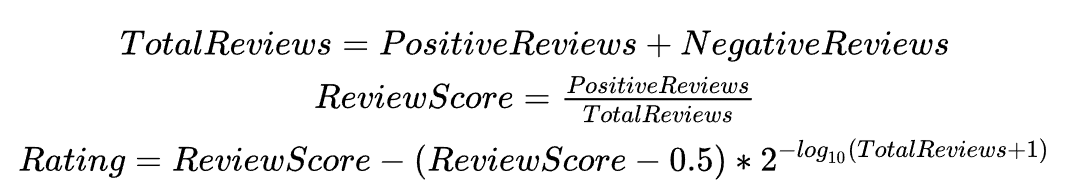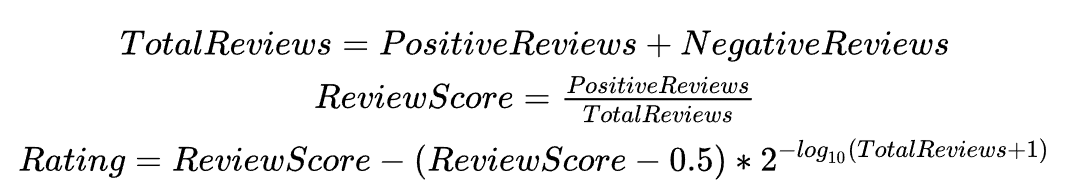

In [166]:
reviews['rating'] = (
                        reviews['total_positive']/reviews['total_reviews'] - 
                        (reviews['total_positive']/reviews['total_reviews'] - 0.5)*np.power(2,-np.log10(reviews['total_reviews']+1))
                    )*100

Let's check the games with the highest reviews:

In [167]:
temp_df = pd.concat([storefront,reviews], ignore_index=False, axis = 1)
temp_df.sort_values(by='rating', ascending = False)[['name','review_score','total_positive','total_negative','rating']]

,name,review_score,total_positive,total_negative,rating
appid,,,,,
620,Portal 2,9.0,302160.0,3691.0,97.704133
427520,Factorio,9.0,131118.0,1417.0,97.526074
1118200,People Playground,9.0,135560.0,1547.0,97.482860
1794680,Vampire Survivors,9.0,119892.0,1363.0,97.434644
1145360,Hades,9.0,195426.0,2735.0,97.383147
...,...,...,...,...,...
2146600,I commissioned some bees 7,0.0,0.0,0.0,NaN
2147130,Crazy Edition of Stunts,0.0,0.0,0.0,NaN
2147260,Extermination Cars Stadium,0.0,0.0,0.0,NaN


This correlates with what we see at https://steamdb.info/stats/gameratings/ . As you can see, the numbers of reviews are somewhat different, the reason being that we've downloaded only reviews for people that bought the game from Steam.

In [168]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109535 entries, 10 to 2148230
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   review_score       109535 non-null  float64
 1   review_score_desc  109535 non-null  object 
 2   total_positive     109535 non-null  float64
 3   total_negative     109535 non-null  float64
 4   total_reviews      109535 non-null  float64
 5   download_appid     109529 non-null  float64
 6   metacritic_score   3861 non-null    object 
 7   metacritic_url     3861 non-null    object 
 8   rating             78008 non-null   float64
dtypes: float64(6), object(3)
memory usage: 12.4+ MB


In the mathematical operations we got a lot of NaNs, due to games with 0 total reviews. Let's assign them a score of 50%, as the medium point. This is the same approach used in the algorithm above.

In [169]:
reviews['rating'] = reviews['rating'].fillna(50.0)

Let's also remove the excessive entries from reviews if they are present:

In [170]:
def df_remove_excesses(df_primary, df_secondary):
    excesses = df_secondary.index.difference(df_primary.index)
    df_secondary = df_secondary.drop(excesses, axis=0)
    return df_secondary

And remove the field that contain the excessive information:
* total_reviews - we can calculate them by using total_positive and total_negative
* review_score_desc - we can describe the scores in the review_score metadata if needed.
* download_appid - it is no longer needed

In [171]:
reviews = df_remove_excesses(storefront,reviews)
reviews.drop([
        'total_reviews', 'review_score_desc', 'download_appid'
    ], axis=1, inplace = True)

We'll decide how we are going to  join/split the table close to the end and leave the reviews for now.

# SteamSpy table

This table contains data collected from SteamSpy. The columns are:

| Column  | Description |
| --- | --- |
| appid | Appid, used as index |
| name | Application name |
| developers | Application developers |
| publishers | Application publishers |
| score_rank| Steam reviews score rank |
| total_positive | Positive reviews count|
| total_negative | Negative reviews count |
| review_score | Steam review score |
| owners | Estimated owner numbers |
| average_forever | Average playtime |
| average_2weeks | Average playtime in the last two weeks |
| median_forever | Median playtime |
| median_2weeks | Median playtime in the last two weeks |
| price | Current game price |
| initialprice | Initial game price |
| discount | Discount |
| supported_languages | Supported languages |
| genres | App Genres |
| ccu | Peak concurrent players on the day before the data collection (*not the max historical!*) |
| tags | User tags with counts |


We have already got the clean data for most of the fields from the Storefront and Reviews tables. Also, the data from SteamSpy is not as complete and recent comparing to the one directy downloaded from Steam. These columns are:
- appid
- name
- developers
- publishers
- score_rank
- total_positive
- total_negative
- review_score
- price
- initialprice
- discount
- supported_languages
- genres
 
I'll still take a quick look on this fields one by one.

The columns we are interested in:
- owners
- average_forever
- average_2weeks
- median_forever
- median_2weeks
- ccu
- tags

### Conforming the table rows to the same ids as in the main storefront table:


In [172]:
steamspy = df_remove_excesses(storefront,steamspy)


I'll create a temporary table merging storefront, reviews and steamspy for the steamspy data check

In [173]:
storefront_s = pd.concat([storefront, reviews.add_suffix('_reviews'), steamspy.add_suffix('_steamspy')], axis = 1)

## Columns we already have good data data on
### name
Application name. We've already worked with it on the storefront so it's of no use to us.

In [174]:
print('name nulls count:', steamspy['name'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[['name', 'name_steamspy']].sample(5))

name nulls count: 213


,name,name_steamspy
appid,,
1696230,Peblito: Rock and Roll,Peblito: Rock and Roll
1448880,Unity Invaders,Unity Invaders
1022493,DFF NT: Root of Evil Appearance Set for Exdeath,DFF NT: Root of Evil Appearance Set for Exdeath
962300,Cao Xiu - Officer Ticket / 曹休使用券,Cao Xiu - Officer Ticket / 曹休使用券
351990,Riff Racer - Race Your Music!,Riff Racer - Race Your Music!


### developers
Developers. We've already worked with it on the storefront so it's of no use to us.

In [175]:
print('developers nulls count:', storefront_s['developers_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[['name', 'developers', 'developers_steamspy']].sample(5))

developers nulls count: 14257


,name,developers,developers_steamspy
appid,,,
461280,Missileman Origins,['Ryan Silberman'],Ryan Silberman
1279770,Tower of God,['MoonlightGames'],MoonlightGames
1600100,Flexibility and Girls,['Kotovodk Studio'],Sweety Cute Studio
349660,SCHAR: Blue Shield Alliance Soundtrack,['Brainshape Games'],Brainshape Games
271413,Rocksmith® 2014 – Aerosmith - “Legendary Child”,['Ubisoft - San Francisco'],Ubisoft - San Francisco


### publishers
Publishers. We've already worked with it on the storefront so it's of no use to us.

In [176]:
print('publishers nulls count:', storefront_s['publishers_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[['name', 'publishers', 'publishers_steamspy']].sample(5))

publishers nulls count: 23562


,name,publishers,publishers_steamspy
appid,,,
874150,Block Heads: Instakill - Military Skin Pack,['Madar Games'],Madar Games
1277160,Aquarium Life,['Sony'],Sony
1857070,Golden Mine Pickaxe,['Neki4 Electronics'],Neki4 Electronics
385420,Dex - Soundtrack,['Dreadlocks Ltd'],NaN
1936750,Left Stranded,['DevBre'],NaN


### score_rank
Steam review score rank. We've already worked with it on the storefront so it's of no use to us.

In [177]:
print('score_rank nulls count:', storefront_s['score_rank_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['score_rank_steamspy'].notnull()][['name', 'rating_reviews', 'score_rank_steamspy']].sample(5))

score_rank nulls count: 108808


,name,rating_reviews,score_rank_steamspy
appid,,,
780020,True Puzzle,65.119119,98.0
944540,House Party - Explicit Content Add-On,67.182431,100.0
823550,Booty Calls,55.348955,97.0
896890,VR Paradise - Steam Edition,80.828588,99.0
914850,HENTAI PUZZLE,77.677260,100.0


### total_positive
Total number of positive reviews. We've already worked with it on the storefront so it's of no use to us.

In [178]:
print('total_positive nulls count:', storefront_s['total_positive_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['total_positive_steamspy']>0][['name', 'total_positive_reviews', 'total_positive_steamspy']].sample(5))

total_positive nulls count: 2953


,name,total_positive_reviews,total_positive_steamspy
appid,,,
1959440,Balance Knight,1.0,1.0
942300,✌ Johnny Rocket,19.0,19.0
344820,Forsaken Fortress Strategy,67.0,66.0
1538680,Blake: The Visual Novel,38.0,35.0
780000,Critical Mess,4.0,4.0


### total_negative
Total number of negative reviews. We've already worked with it on the storefront so it's of no use to us.

In [179]:
print('total_negative nulls count:', storefront_s['total_negative_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['total_negative_steamspy']>0][['name', 'total_negative_reviews', 'total_negative_steamspy']].sample(5))

total_negative nulls count: 2953


,name,total_negative_reviews,total_negative_steamspy
appid,,,
1781880,Hardwork Simulator,3.0,3.0
8400,Geometry Wars: Retro Evolved,87.0,86.0
731790,Fly Destroyer,11.0,11.0
1613000,旅途,3.0,3.0
1158390,Divan Chronicles,10.0,10.0


### review_score
Review score. We've already worked with it on the storefront so it's of no use to us.

In [180]:
print('review_score nulls count:', storefront_s['review_score_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['review_score_steamspy']>0][['name', 'review_score_reviews', 'review_score_steamspy']].sample(5))

review_score nulls count: 2953


,name,review_score_reviews,review_score_steamspy
appid,,,
906050,Hentai Case Opening,6.0,63.0
962380,HOT FIT!,6.0,80.0
343611,Call of Duty®: Advanced Warfare - Extra Armory Slots 1,4.0,25.0
958480,Seed of the Dead,6.0,84.0
891870,King of Phoenix,5.0,84.0


### price
Current price (including discounts). We've already worked with it on the storefront so it's of no use to us.

In [181]:
print('price nulls count:', storefront_s['price_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['price_steamspy']>0][['name', 'price', 'price_steamspy']].sample(5))

price nulls count: 13948


,name,price,price_steamspy
appid,,,
364410,Invite the Dwarves to Dinner,1.99,69.0
1159328,[Revival] DOA6 Sexy Bunny Costume - Momiji,1.99,199.0
1153850,Super Space Towers,10.79,1299.0
281240,Adventure Chronicles: The Search For Lost Treasure,4.99,499.0
1306240,Freelance Trucker: Insurance Fraud Edition,7.39,899.0


### initialprice
Price without the discount. We've already worked with it on the storefront so it's of no use to us.

In [182]:
print('price nulls count:', storefront_s['initialprice_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['initialprice_steamspy']>0][['name', 'price', 'initialprice_steamspy']].sample(5))

price nulls count: 13946


,name,price,initialprice_steamspy
appid,,,
1022345,DFF NT: Devoted Returner Appearance Set for Locke Cole,2.99,299.0
836820,Pinball FX3 - Star Wars™ Pinball: The Last Jedi™,6.99,699.0
314470,Heroes of a Broken Land,11.99,1499.0
1535740,Fantasy Grounds - D&D Candlekeep Mysteries,24.99,2999.0
222616,Train Simulator: WSR Diesels Loco Add-On,13.99,1999.0


### discount
Current dicount. We've already worked with it on the storefront so it's of no use to us.

In [183]:
print('discount nulls count:', storefront_s['discount_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['discount_steamspy']>0][['name', 'price_steamspy', 'initialprice_steamspy', 'discount_steamspy']].sample(5))

discount nulls count: 13946


,name,price_steamspy,initialprice_steamspy,discount_steamspy
appid,,,,
1149261,Ambient DM DLC - (Music) Halloween,449.0,499.0,10.0
1864850,Hidden Map,199.0,1999.0,90.0
379241,FSX: Steam Edition - Jabiru J160 Add-On,799.0,1999.0,60.0
1252200,PAYDAY 2: San Martín Bank Heist,559.0,699.0,20.0
1369453,ViRo - Doggy Style,449.0,599.0,25.0


### supported_languages
Supported languages. Here languages are not divided on autio/text. We've already worked with this data on the storefront so it's of no use to us.

In [184]:
print('supported_languages nulls count:', storefront_s['supported_languages_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['supported_languages_steamspy'].notnull()][[
        'name',
        'supported_audio',
        'supported_languages',
        'supported_languages_steamspy'
    ]].sample(5))

supported_languages nulls count: 14111


,name,supported_audio,supported_languages,supported_languages_steamspy
appid,,,,
2016790,Trainz 2019 DLC - CFR B 26-26 098,<NA>,"[Czech, Dutch, English, French, German, Italian, Polish, Portuguese - Portugal, Russian, Simplified Chinese, Spanish - Spain]","English, French, Italian, German, Spanish - Spain, Russian, Czech, Dutch, Polish, Portuguese, Simplified Chinese"
361110,Prometheus - The Fire Thief,[English],[English],English
1795620,DOOM DAY,"[Arabic, Bulgarian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hungarian, Italian, Japanese, Korean, Norwegian, Polish, Portug...","[Arabic, Bulgarian, Czech, Danish, Dutch, English, Finnish, French, German, Greek, Hungarian, Italian, Japanese, Korean, Norwegian, Polish, Portug...",English
409420,Knight Adventure,<NA>,"[English, Portuguese - Brazil, Russian, Spanish - Spain]","English, Spanish - Spain, Portuguese - Brazil, Russian"
90210,Farming Simulator 2011 - Equipment Pack 1,<NA>,[English],English


### genres
Genres. We've already worked with this data on the storefront so it's of no use to us.

In [185]:
print('genres nulls count:', storefront_s['genres_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['genres_steamspy'].notnull()][['name', 'genres', 'genres_steamspy']].sample(5))

genres nulls count: 14215


,name,genres,genres_steamspy
appid,,,
925821,SENRAN KAGURA Burst Re:Newal - Cutie ❤ Melon,[Action],Action
1748544,Starry Moon Island DNA War MP05,"[Action, Casual, Indie]","Action, Casual, Indie"
1130630,Armello - The Dragon Clan,"[Adventure, Indie, RPG, Strategy]","Adventure, Indie, RPG, Strategy"
1290170,Titan Chaser,"[Adventure, Casual, Indie, Simulation]","Adventure, Casual, Indie, Simulation"
1843932,Paladins Season 4 Champions Bundle,"[Action, Free to Play]","Action, Free to Play"


## Columns requiring analysis

### Owners
SteamSpy owners estimation. A string with lower .. upper application owners estimates. We could split it into two for lower and upper estimations but I'll just slightly reformat it to keep consistent with Nik Davis dataset.

In [186]:
print('owners nulls count:', storefront_s['owners_steamspy'].isnull().sum())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['owners_steamspy'].notnull()][['name', 'owners_steamspy']].sample(5))

owners nulls count: 2953


,name,owners_steamspy
appid,,
341460,Fallen Temple,"0 .. 20,000"
1873460,V-Skin 2D Offical Stage Pack,"0 .. 20,000"
847100,Тридевятые земли(Свет или тьма),"0 .. 20,000"
1619830,Mello,"0 .. 20,000"
1371800,My Nuclear Octopus,"0 .. 20,000"


#### [Subroutine] 'owners': Cleaning

In [187]:
def owners_clean(df):
    '''
    Reformatting owners column to lower-upper format
    '''
    df = df.copy()
    df['owners'] = df['owners'].str.replace(',', '', regex=True).str.replace(' .. ', '-', regex=True)
    return df

In [188]:
steamspy = owners_clean(steamspy)

In [189]:
steamspy.sample(10)

,name,developers,publishers,score_rank,total_positive,total_negative,review_score,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,supported_languages,genres,ccu,tags
appid,,,,,,,,,,,,,,,,,,,
1959770,Trainz Plus DLC - Znamensk-Svir,Rimys,N3V Games,NaN,0,0,0,0-20000,0,0,0,0,1999.0,1999.0,0.0,"English, French, Italian, German, Spanish - Sp...",Simulation,0,[]
620310,Bonny's Adventure,"Jonas De Carvalho Felinto, Marcelo Eduardo Cabral","Jonas De Carvalho Felinto, Marcelo Eduardo Cabral",NaN,11,1,0,20000-50000,414,0,464,0,399.0,399.0,0.0,English,"Action, Adventure, Casual, Indie",0,"{'Adventure': 40, 'Indie': 31, 'Action': 21, '..."
1797280,Chernobylite - Autumn Dread Pack,The Farm 51,"The Farm 51, All In! Games",NaN,0,0,0,0-20000,0,0,0,0,399.0,399.0,0.0,"English, Russian, French, German, Polish, Span...","Action, Adventure, Indie, RPG, Simulation",0,[]
358760,Selenon Rising,Fastermind Games,Sekai Project,NaN,14,3,0,0-20000,0,0,0,0,599.0,599.0,0.0,English,"Adventure, Casual, Indie",0,"{'Indie': 22, 'Adventure': 21, 'Casual': 20, '..."
1955120,Nemire,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
1936710,怪物狩猎：序章,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
1769160,Whispers of Ancient Stone,NaN,NaN,NaN,0,0,0,0-20000,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,[]
1628130,Who Pressed Mute on Uncle Marcus?,"Wales Interactive, Good Gate Media",Wales Interactive,NaN,202,60,0,20000-50000,0,0,0,0,597.0,1299.0,54.0,"English, French, German, Russian, Simplified C...",Adventure,2,"{'FMV': 159, 'Adventure': 149, 'Singleplayer':..."
449600,Elemental Heroes - Quick Starter Pack,mPower Games Studio,mPower Games Studio,NaN,0,0,0,0-20000,0,0,0,0,999.0,999.0,0.0,"English, Russian","Free to Play, Massively Multiplayer, RPG, Stra...",0,[]


### average_forever 

Average player playtime. We have some nulls (since we don't have data for some games). We will replace it with 0 to keep consistent with data on SteamSpy.

In [190]:
print('average_forever nulls count:', storefront_s['average_forever_steamspy'].isnull().sum())
print('average_forever zero count:', storefront_s[storefront_s['average_forever_steamspy']==0]['average_forever_steamspy'].count())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['average_forever_steamspy'].notnull()][['name', 'average_forever_steamspy']].sample(5))

average_forever nulls count: 2953
average_forever zero count: 91813


,name,average_forever_steamspy
appid,,
418190,Helen's Mysterious Castle,1.0
1894450,11 Islands 2: Story of Love,0.0
419943,GGXrd Extra Color Palettes - MILLIA RAGE,0.0
1195060,SWEET MILF -Episode Rumiko-,0.0
1685350,Tiger Tank 59 Ⅰ Black Hill Fortress MP001,0.0


#### [Subroutine] 'average_forever': Cleaning

In [191]:
def average_forever_clean(df):
    '''
    Cleaning average_forever in SteamSpy
    '''
    df = df.copy()
    df['average_forever'].fillna(0)
    return df

In [192]:
steamspy = average_forever_clean(steamspy)

### average_2weeks 

Average player playtime in the last 2 weeks. While the data is interesting, it's only the last two weeks so it doesn't seem valuable in the long term. Going to drop.

In [193]:
print('average_2weeks nulls count:', storefront_s['average_2weeks_steamspy'].isnull().sum())
print('average_2weeks zero count:', storefront_s[storefront_s['average_2weeks_steamspy']==0]['average_2weeks_steamspy'].count())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['average_2weeks_steamspy'].notnull()][['name', 'average_2weeks_steamspy']].sample(5))

average_2weeks nulls count: 2953
average_2weeks zero count: 104222


,name,average_2weeks_steamspy
appid,,
1631160,Logic Car,0.0
1687802,Tiger Tank 59 Ⅰ Break The Fog MP003,0.0
1562880,Ponk's Jam,0.0
881100,Noita,190.0
1286870,Nevertales: Hearthbridge Cabinet Collector's Edition,0.0


### median_forever 

Median player playtime. We have some nulls (since we don't have data for some games). We will replace it with 0 to keep consistent with data on SteamSpy.

In [194]:
print('median_forever nulls count:', storefront_s['median_forever_steamspy'].isnull().sum())
print('median_forever zero count:', storefront_s[storefront_s['median_forever_steamspy']==0]['median_forever_steamspy'].count())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['median_forever_steamspy'].notnull()][['name', 'median_forever_steamspy']].sample(5))

median_forever nulls count: 2953
median_forever zero count: 91813


,name,median_forever_steamspy
appid,,
405310,LEGO® MARVEL's Avengers,1192.0
682000,Solmec: Among Stars,0.0
1607500,Schmutznik,0.0
786410,An Aspie Life,4.0
1522250,RoboSquare - Blue Force Field Bundle,0.0


#### [Subroutine] 'median_forever': Cleaning

In [195]:
def median_forever_clean(df):
    '''
    Cleaning average_forever in SteamSpy
    '''
    df = df.copy()
    df['median_forever'].fillna(0)
    return df

In [196]:
steamspy = median_forever_clean(steamspy)

### median_2weeks 

Median player playtime in the last 2 weeks. While the data is interesting, it's only the last two weeks so it doesn't seem valuable in the long term. Going to drop.

In [197]:
print('median_2weeks nulls count:', storefront_s['median_2weeks_steamspy'].isnull().sum())
print('median_2weeks zero count:', storefront_s[storefront_s['median_2weeks_steamspy']==0]['median_2weeks_steamspy'].count())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['median_2weeks_steamspy'].notnull()][['name', 'median_2weeks_steamspy']].sample(5))

median_2weeks nulls count: 2953
median_2weeks zero count: 104222


,name,median_2weeks_steamspy
appid,,
1009870,Bet on Man,0.0
1346910,H-SNIPER: World War II - Nudity DLC (18+),0.0
613450,Please Knock on My Door,0.0
749410,Season's Beatings,0.0
568300,The Sibling Experiment,0.0


### ccu 

Peak concurrent user count. This is a very interesting stat. Sadly, it's not a lifetime stat, but the stat for the day before the dataset is downloaded so it's not useful for analysis. Going to drop.

In [198]:
print('ccu nulls count:', storefront_s['ccu_steamspy'].isnull().sum())
print('ccu zero count:', storefront_s[storefront_s['ccu_steamspy']==0]['ccu_steamspy'].count())
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['ccu_steamspy'].notnull()][['name', 'ccu_steamspy']].sample(5))

ccu nulls count: 2953
ccu zero count: 89821


,name,ccu_steamspy
appid,,
957761,"Nonogram - Master's Legacy, Classic Pack",0.0
1219410,Hot And Lovely - patch,0.0
1033503,RPG Maker MV - Mythos Reawakening,0.0
1717180,Xenocider,0.0
1993530,DEAD ZONE,0.0


### tags

User tags data. It includes both the tag and the number of users that put the tag. A dict with 'tag_name':tag_count elements.

I'll save just the tags themselves in the main table and move tags with tag numbers to the separate one.

In [199]:
print('tags nulls count:', storefront_s['tags_steamspy'].isnull().sum())
print('tags empty list count:', storefront_s[~storefront_s['tags_steamspy'].apply(lambda x: False if pd.isna(x) else bool(ast.literal_eval(x)))].shape[0])
with pd.option_context('display.max_colwidth', 150):
    display(storefront_s[storefront_s['tags_steamspy'].notnull()][['name', 'tags_steamspy']].sample(5))

tags nulls count: 2953
tags empty list count: 46722


,name,tags_steamspy
appid,,
1107340,LONN,[]
1649280,Mémoire d'Arumac,[]
1531040,Pavlov's House,"{'Strategy': 67, 'Board Game': 42, 'Wargame': 38, 'World War II': 35, 'Tabletop': 32, 'Singleplayer': 25, 'Top-Down': 22, '2D': 20}"
585310,Beyond the City VR,"{'Strategy': 22, 'Action': 21, 'Indie': 21, 'Early Access': 21, 'Casual': 21, 'VR': 10}"
559170,"Ready, Aim, Splat!","{'Action': 21, 'Indie': 21, 'Casual': 21, 'VR': 7}"


#### [Subroutine] 'tags': Cleaning

In [200]:
def clean_tags(df, export=False):
    '''
    Processing SteamSpy tags with possible export.
    For exporting, we are spreading the tags to columns and put the number of users using the said tag as a value
    tags are renamed to comply with pandas column names requirements    
    
    We are leaving only the tags themselves in the table
    '''    
    if export: 
        
        tag_data = df[['tags']].copy()
        
        def parse_export_tags(x):
            if pd.isnull(x):
                return {}
            x = ast.literal_eval(x)

            if isinstance(x, dict):
                return x
            elif isinstance(x, list):
                return {}
            else:
                raise TypeError('Something other than dict or list found')

        tag_data['tags'] = tag_data['tags'].apply(parse_export_tags)

        # Getting all tags for column names
        cols = set(itertools.chain(*tag_data['tags']))

        # And setting the user values
        for col in sorted(cols):
            col_name = col.lower().replace(' ', '_').replace('-', '_').replace("'", '')

            tag_data[col_name] = tag_data['tags'].apply(lambda x: x[col] if col in x.keys() else 0)

        tag_data = tag_data.drop('tags', axis=1)
        
        export_data(tag_data, 'steamspy_tag_data', index=True)
        print('Exported tag data')
        
        
    def parse_tags(x):
        if pd.isnull(x):
            return pd.NA
        x = ast.literal_eval(x)
        
        if isinstance(x, dict):
            return list(x.keys())
        else:
            return pd.NA
    
    df['tags'] = df['tags'].apply(parse_tags)
       
    return df

In [201]:
steamspy = clean_tags(steamspy, export = True)

C:\Users\ilkar399\AppData\Local\Temp/ipykernel_24152/3985817278.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tag_data[col_name] = tag_data['tags'].apply(lambda x: x[col] if col in x.keys() else 0)


Exported steamspy_tag_data to "../data/export/steamspy_tag_data.csv"
Exported tag data


In [202]:
#Verifying exported data
pd.read_csv('../data/export/steamspy_tag_data.csv').sample(10)

,appid,1980s,1990s,2.5d,2d,2d_fighter,2d_platformer,360_video,3d,3d_fighter,...,well_written,werewolves,western,wholesome,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
17984,517270,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78509,1559590,0,0,0,0,0,0,0,25,0,...,0,0,0,0,0,0,0,0,0,0
100360,1933730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15532,468490,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85755,1685377,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59162,1217410,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95740,1842880,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95528,1838881,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52951,1122611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57416,1192700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### [Subroutine] SteamSpy: dropping columns

In [203]:
steamspy = steamspy.drop([
        'name', 'developers', 'publishers', 'score_rank', 'total_positive', 'total_negative', 'review_score',
    'price', 'initialprice', 'discount', 'supported_languages', 'genres', 'average_2weeks', 'median_2weeks',
    'ccu'
    ], axis=1)

After the processing, our SteamSpy data table will look like this:

In [204]:
steamspy.sample(10)

,owners,average_forever,median_forever,tags
appid,,,,
1697780,0-20000,0,0,"[Sexual Content, Female Protagonist, LGBTQ+, N..."
1883480,0-20000,0,0,"[Sports, Casual, VR, Simulation, Hockey, Singl..."
1222940,20000-50000,0,0,"[Free to Play, Sports, Racing, Driving, Arcade..."
945590,0-20000,0,0,"[Casual, Simulation, Adventure, Indie, Otome, ..."
753520,0-20000,0,0,<NA>
540740,0-20000,0,0,"[Simulation, Relaxing, VR, Atmospheric, First-..."
1406990,200000-500000,280,111,"[Sexual Content, Anime, Hentai, Visual Novel, ..."
1601670,0-20000,0,0,<NA>
256190,200000-500000,438,581,"[Action, FPS, World War II, Shooter, Singlepla..."


We'll combine it with storefront and review data into one Steam data table:

In [205]:
steam = pd.concat([storefront,reviews,steamspy], ignore_index=False, axis = 1)

In [206]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108854 entries, 10 to 2148230
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   type                     108854 non-null  object 
 1   name                     108854 non-null  object 
 2   required_age             108854 non-null  int64  
 3   dlc                      10159 non-null   object 
 4   fullgame                 36356 non-null   object 
 5   supported_languages      108709 non-null  object 
 6   drm_notice               745 non-null     object 
 7   ext_user_account_notice  1097 non-null    object 
 8   developers               108821 non-null  object 
 9   publishers               108822 non-null  object 
 10  demos                    7249 non-null    object 
 11  packages                 85582 non-null   object 
 12  platforms                108854 non-null  object 
 13  categories               108722 non-null  object 
 14  ge

In [207]:
steam.sample(10)

,type,name,required_age,dlc,fullgame,supported_languages,drm_notice,ext_user_account_notice,developers,publishers,...,review_score,total_positive,total_negative,metacritic_score,metacritic_url,rating,owners,average_forever,median_forever,tags
appid,,,,,,,,,,,,,,,,,,,,,
264841,dlc,Realms of Arkania: Blade of Destiny - Ogredeat...,0,NaN,237550,"[English, German]",NaN,NaN,['Crafty Studios'],['United Independent Entertainment'],...,0.0,4.0,0.0,<NA>,<NA>,69.199408,0-20000,0.0,0.0,"[RPG, Adventure, Indie]"
1914000,game,Sweet Car Wash,0,"[2118790, 2118880]",<NA>,[English],NaN,NaN,['Kotovodk Studio'],['Kotovodk Studio'],...,0.0,6.0,0.0,<NA>,<NA>,72.166351,0-20000,0.0,0.0,<NA>
477190,game,Epic Snowday Adventure,0,NaN,<NA>,[English],NaN,NaN,"['Verge of Brilliance LLC', 'Evie Powell', 'Ni...",['Verge of Brilliance LLC'],...,0.0,4.0,1.0,<NA>,<NA>,62.506594,0-20000,0.0,0.0,"[Action, Indie, VR]"
712340,dlc,Order of Battle: Panzerkrieg,0,NaN,312450,"[English, French, German, Russian, Spanish - S...",NaN,NaN,['The Artistocrats'],['The Artistocrats'],...,7.0,25.0,2.0,<NA>,<NA>,76.972051,0-20000,0.0,0.0,"[Strategy, Simulation]"
340020,game,NoseBound,0,NaN,<NA>,"[English, Italian, Spanish - Spain]",NaN,NaN,['Quarantine Interactive'],['Quarantine Interactive'],...,0.0,0.0,0.0,<NA>,<NA>,50.000000,0-20000,0.0,0.0,<NA>
333771,dlc,Spriter: Basic Platformer Pack,0,NaN,332360,[English],NaN,NaN,['BrashMonkey'],['BrashMonkey'],...,0.0,1.0,0.0,<NA>,<NA>,59.416365,0-20000,0.0,0.0,"[Design & Illustration, Utilities, Animation &..."
1764730,game,История бомжа 2: полицейский беспредел,0,NaN,<NA>,[Russian],NaN,NaN,['Quarlellle'],['Quarlellle'],...,7.0,15.0,3.0,<NA>,<NA>,69.594952,0-20000,0.0,0.0,"[Indie, Adventure, Action, Third Person, Comed..."
1764940,game,The Joys of Discovery,0,NaN,<NA>,[English],NaN,NaN,['Kenningsly'],['Kenningsly Production'],...,0.0,0.0,0.0,<NA>,<NA>,50.000000,0-20000,0.0,0.0,<NA>
334230,game,Town of Salem,0,"[626470, 648420]",<NA>,"[English, Spanish - Spain]",NaN,NaN,['BlankMediaGames'],['BlankMediaGames'],...,8.0,30817.0,3883.0,<NA>,<NA>,87.141928,1000000-2000000,1846.0,1046.0,"[Multiplayer, Strategy, Mystery, Indie, RPG, S..."


# Finalizing table structure

After the processing have these tables available:

* steam
* steam_description_data
* steam_media_data
* steam_packages_info
* steam_requirements_data
* steam_support_info
* steamspy_tag_data
* missing_ids

Sadly, there are a lot of optional data in the steam table so it might be a good idea to move it to the optional table and join with the main table when necessary. The fields that go to the **steam_optional** are:

* drm_notice
* ext_user_account_notice
* demos
* content_descriptors
* metacritic_score
* metacritic_url

### [Subroutine] steam and steam_optional export

In [208]:
def steam_export(df):
    '''
    Creating steam_optional table and exporting both steam and steam_optional
    '''
    df = df.copy()
    # copying necessary columns into new df
    steam_optional_df = df[[
        'drm_notice',
        'ext_user_account_notice',
        'demos',
        'content_descriptors',
        'metacritic_score',
        'metacritic_url',
    ]].copy()
    
    # removing empty rows
    steam_optional_df.dropna(how = 'all', inplace=True)
           
    # dropping unnneeded columns from the main dataframe
    df = df.drop([
        'drm_notice',
        'ext_user_account_notice',
        'demos',
        'content_descriptors',
        'metacritic_score',
        'metacritic_url',
    ], axis=1)
    
    export_data(df, 'steam', index=True)
    export_data(steam_optional_df, 'steam_optional', index=True)

In [209]:
steam_export(steam)

Exported steam to "../data/export/steam.csv"
Exported steam_optional to "../data/export/steam_optional.csv"


In [210]:
# Verifying exported steam data
pd.read_csv('../data/export/steam.csv').sample(5)

,appid,type,name,required_age,dlc,fullgame,supported_languages,developers,publishers,packages,...,coming_soon,price,review_score,total_positive,total_negative,rating,owners,average_forever,median_forever,tags
52882,1120970,game,Dream Keeper,0,NaN,NaN,['English'],"['Dern Lin', 'Dergan Lin']",['DDLin'],[379961],...,False,1.59,0.0,4.0,0.0,69.199408,0-20000,0.0,0.0,"['Strategy', 'Action', 'Indie', 'Casual', 'Car..."
60490,1237721,dlc,Coloring Pixels - Music Pack,0,NaN,897330.0,['English'],['ToastieLabs'],['ToastieLabs'],[429333],...,False,0.79,5.0,17.0,21.0,46.483823,0-20000,0.0,0.0,NaN
21014,570840,game,家有大貓 Nekojishi,0,"[754770, 769180, 848320]",NaN,"['English', 'Japanese', 'Simplified Chinese', ...","['Studio Klondike', 'Team Nekojishi']","['Studio Klondike', 'Orange Juice Dog']",NaN,...,False,0.00,8.0,3621.0,290.0,89.054510,200000-500000,293.0,188.0,"['Sexual Content', 'LGBTQ+', 'Free to Play', '..."
580,24028,dlc,Train Simulator: Rascal & Cottonwood Route Add-On,0,NaN,24010.0,['English'],['All Aboard'],['Dovetail Games - Trains'],[2072],...,False,18.99,5.0,5.0,6.0,47.605897,0-20000,0.0,0.0,"['Simulation', 'Trains', 'Co-op', 'Open World'..."
89448,1726290,game,The Last Defense,0,NaN,NaN,['English'],['ThugGames'],['ThugGames'],[618291],...,False,8.19,0.0,1.0,3.0,40.400296,0-20000,0.0,0.0,"['Tower Defense', 'Story Rich', 'Difficult', '..."


In [211]:
# Verifying exported steam_optional data
pd.read_csv('../data/export/steam_optional.csv').sample(5)

,appid,drm_notice,ext_user_account_notice,demos,content_descriptors,metacritic_score,metacritic_url
22196,1895780,NaN,NaN,NaN,Sexy Space Airlines contains scenes showing un...,NaN,NaN
24251,2083920,NaN,NaN,NaN,"Execution, Murder, Gun & Hostage situation",NaN,NaN
20134,1762230,NaN,NaN,NaN,Multiplayer - Mature Players Only\r\nImmature ...,NaN,NaN
11024,1196550,NaN,NaN,[1197130],NaN,NaN,NaN
5475,809230,NaN,NaN,NaN,NaN,88.0,https://www.metacritic.com/game/pc/unity-of-co...


### [Subroutine] missing_ids export

In [212]:
export_data(missing_ids, 'missing_ids', index=True)

Exported missing_ids to "../data/export/missing_ids.csv"


# Combined clean-up script

# TODO

In [213]:
def combined_cleanup():
    
    
    return True

# Tests

In [214]:
# Testing if the number of rows is consistent between the pre and post processing
def row_check():
    pre_count = pd.read_csv('../data/processing/steam_app_data.csv').shape[0]
    print('Number of rows before processing:', pre_count)
    missing_count_pre = pd.read_csv('../data/processing/missing_ids.csv').shape[0]
    print('Number of missing before processing:', missing_count_pre)
    post_count = pd.read_csv('../data/export/steam.csv').shape[0]
    print('Number of rows after processing:', post_count)
    missing_count_post = pd.read_csv('../data/export/missing_ids.csv').shape[0]
    print('Number of missing after processing:', missing_count_post)
    if ((pre_count + missing_count_pre) <= (post_count + missing_count_post)):
        return True
    return False

In [215]:
print('Number of rows test results:', row_check())

C:\Users\ilkar399\AppData\Local\Temp/ipykernel_24152/569893746.py:1: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  print('Number of rows test results:', row_check())


Number of rows before processing: 109535
Number of missing before processing: 0
Number of rows after processing: 108854
Number of missing after processing: 709
Number of rows test results: True
